In [6]:
import io
import subprocess
import os
import glob

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/MB_PanCancer_LoD_simulation_01082024"

# Data preocessing

## Process Parker cohort

In [10]:
#Readin samples from Parker cohort of Infinity TB all_cols.csv file shared by Jing 
df_parker = pd.read_csv("/ghsfa/projects/pharma/customers/ParkerInstitutePICI/Infinity/PIC_RP_01_Infinity/PIC_RP_01_Infinity_02/data/report/3rd_run/12252023_PIC_RP01_02_tb_changed_all_cols.csv", header = 1) 

print("Total sample size of Parker cohort is " + str(df_parker.shape[0]) + "\n") 
print("Total unique sample size of Parker cohort is " + str(df_parker.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of Parker cohort is " + str(df_parker.Patient_ID.nunique()) + "\n")
df_parker.head()

Total sample size of Parker cohort is 105742

Total unique sample size of Parker cohort is 1409

Total unique patient sample size of Parker cohort is 548



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Study ID,Patient ID,Customer Sample ID,Sample Time point,plasma_volume_manifest,Sample Type,Cancer Stage,requestcreatedt,bloodcolldate,sample_received_date,cancerother,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,plasma_volume_observed,Batch_ID,new_Cancertype,Cancer_Type_in_Cohort,new_Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_Standardized,call,ldt_reportable,ruo_reportable,variant_comment,Final_RUO_call,on_OMNI,on_G360,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,cn_deletion_sample_comment,cnv_tumor_fraction,hyper_score,on_target_dmr_count,off_target_dmr_count,total_dmr_count,hyper_flag,runid,chry_nonsingleton,contam_vscore,dinucleosome_peak,dm_probes,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_95_lower,methyl_95_upper,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,sample_contamination_pct,sample_coverage_exceptions_ldt,warning,num_fusion_in_homdel,num_somvar_in_homdel,methyl_pos_capture_min
0,PICI0009,BK14846EP01,A0723619,B00538703,PICI0009.PICI0009-3-1309,12 MONTHS POST 1ST DOSE,1,SUCCESS,NaN,SNV,NaN,SESN2,1,28595751.0,2.0,V50M,G>A,c.148G>A,NM_031459.5,52.98,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV53429244,rs148732943,NaN,NaN,NaN,NaN,3223.0,19.56,NaN,NaN,Detected,0.110817,11.34,Low,Not Detected,18.616,1.0,0.0,03/14/2023,08/07/2020,12/25/2023,Urothelial carcinoma (UC),Not Applicable,Not Applicable,PICI0009,PICI0009.PICI0009-3-1309,BK14846EP01,12 MONTHS POST 1ST DOSE,1.0,Plasma,NaN,04/13/2023,08/07/2020,03/14/2023,Urothelial carcinoma (UC),NaN,ACCCATTGCA,GGTCCTCTCA,Shortened_Targeted_SEQ,EIO_PlateI_A11,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,A11,1.0,PS3C-255,Urothelial carcinoma (UC),NaN,NaN,NaN,NaN,1.0,0.0,1.0,germline pval,1.0,Yes,No,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.248991,3.0,2.0,BREAST,24.64775,37.1925,24.64775,20.74831,22.46395,6,NaN,0.19,6,77,0,77,NaN,231118_A01907_0174_BHKJHYDSX7,0.0,2.0,322.0,77.0,0.00133,2766.0,1.246,0.83,0.04,12.0,12.0,133364.0,0.000037,1.21366,0.02,2.0,NaN,NaN,NaN,1.21366
1,PICI0009,BK14846EP01,A0723619,B00538703,PICI0009.PICI0009-3-1309,12 MONTHS POST 1ST DOSE,1,SUCCESS,NaN,SNV,NaN,KMT2B,19,36223413.0,28.0,A1988G,C>G,c.5963C>G,NM_014727.3,52.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3042.0,19.56,NaN,NaN,Detected,0.110817,11.34,Low,Not Detected,18.616,1.0,0.0,03/14/2023,08/07/2020,12/25/2023,Urothelial carcinoma (UC),Not Applicable,Not Applicable,PICI0009,PICI0009.PICI0009-3-1309,BK14846EP01,12 MONTHS POST 1ST DOSE,1.0,Plasma,NaN,04/13/2023,08/07/2020,03/14/2023,Urothelial carcinoma (UC),NaN,ACCCATTGCA,GGTCCTCTCA,Shortened_Targeted_SEQ,EIO_PlateI_A11,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,A11,1.0,PS3C-255,Urothelial carcinoma (UC),NaN,NaN,NaN,NaN,1.0,0.0,1.0,germline pval,1.0,No,No,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.248991,3.0,2.0,BREAST,24.64775,37.19

In [11]:
#Readin a subset Parker samples. Mingyang selected 914 out of 1409 samples as no QC warnings triggered.
#MY also ran the MB Lung v1, MB pan cancer caller on those 914 samples and added some columns to indicate the result
df_parker_clean = pd.read_csv("/ghsfa/projects/pharma/projects/sirius_pharma/mrd_ist/mb_pan_cancer/parker_914_clean_samples_meta.csv", header = 0) 

print("Total sample size of Parker cohort w/t QC warnings is " + str(df_parker_clean.shape[0]) + "\n") 
print("Total unique sample size of Parker cohort w/t QC warnings is " + str(df_parker_clean.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of Parker cohort w/t QC warnings is " + str(df_parker_clean.Patient_ID.nunique()) + "\n")
df_parker_clean.head()

Total sample size of Parker cohort w/t QC warnings is 914

Total unique sample size of Parker cohort w/t QC warnings is 914

Total unique patient sample size of Parker cohort w/t QC warnings is 463



,warning,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,HRD_score,hrd_status,Max_percentage,cfDNA_ng,Plasma_ml_input,Cancertype,fc_dir,runid,chry_nonsingleton,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,cn_deletion_sample_comment,new_Cancertype,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,methyl_95_lower,methyl_95_upper,dinucleosome_peak,dm_probes,on_target_dmr_count,off_target_dmr_count,run_sample_id,methyl_score_MB_Lung_v1,threshold_MB_Lung_v1,methyl_call_MB_Lung_v1,methyl_score_MB_Pan_Cancer,threshold_MB_Pan_Cancer,methyl_call_MB_Pan_Cancer,methyl_call_LR_Aggregated,new_Visit_name
0,NaN,A0723619,B00538703,PICI0009.PICI0009-3-1309,12 MONTHS POST 1ST DOSE,1,SUCCESS,NaN,Detected,0.110817,11.34,Low,Not Detected,NaN,HRD_Neg,19.56,18.616,1.0,Urothelial carcinoma (UC),/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,231118_A01907_0174_BHKJHYDSX7,0.0,2.0,0.00133,2766.0,1.246,0.83,0.04,133364.0,0.000037,1.21366,1.21366,0.02,NaN,Urothelial carcinoma (UC),BREAST,24.64775,37.19250,24.64775,20.74831,22.46395,12.0,12.0,322.0,77.0,77,0,B00538703,11.477615,-20.032878,1,8.147645,-20.86299,1,1,12 months post 1st dose
1,NaN,A0723616,B00538698,PICI0009.PICI0009-3-1773,PRE-TREATMENT,1,SUCCESS,NaN,Detected,0.005843,30.81,High,Not Detected,NaN,HRD_Neg,0.58,8.528,1.0,Urothelial carcinoma (UC),/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,231118_A01907_0174_BHKJHYDSX7,0.0,0.0,0.00000,1248.0,1.422,0.84,0.06,63071.0,0.000396,1.21098,1.21098,0.02,NaN,Urothelial carcinoma (UC),LUNG,10.42780,23.50968,8.35169,3.48606,10.42780,12.0,12.0,324.0,0.0,0,0,B00538698,-6.316503,-20.032878,1,-2.500514,-20.86299,1,1,pre-treatment
2,NaN,A0723615,B00538701,PICI0009.PICI0009-3-1721,PRE-TREATMENT,1,SUCCESS,NaN,Detected,0.000910,7.56,Low,Not Detected,NaN,HRD_Neg,6.26,7.436,1.0,Bladder cancer,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,231118_A01907_0174_BHKJHYDSX7,0.0,0.0,0.00000,987.0,2.003,0.84,0.06,52108.0,0.000038,1.23931,1.23931,0.02,NaN,Bladder cancer,LUNG,0.05464,-0.03561,-14.06017,-10.61117,0.05464,12.0,12.0,319.0,1.0,0,1,B00538701,-21.017365,-20.032878,0,-21.892035,-20.86299,0,1,pre-treatment
3,NaN,A0723613,B00538687,PICI0009.PICI0009-3-1007,4-6 WEEKS POST EOSI,1,SUCCESS,NaN,Detected,0.001187,16.32,Low,Not Detected,NaN,HRD_Neg,0.81,6.136,1.0,Renal cell carcinoma (RCC),/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,231118_A01907_0174_BHKJHYDSX7,0.0,1.0,0.00411,968.0,1.071,0.85,0.05,43561.0,0.000207,1.22899,1.22899,0.02,NaN,Renal cell carcinoma (RCC),LUNG,0.29922,4.37834,-0.29118,-2.92178,0.29922,12.0,12.0,321.0,0.0,0,0,B00538687,-18.545455,-20.032878,1,-22.245143,-20.86299,0,1,4-6 weeks post eosi
4,NaN,A0723611,B00538690,PICI0009.PICI0009-3-1772,PRE-TREATMENT,1,SUCCESS,NaN,Detected,0.669596,8.51,Low,Detected,NaN,HRD_Pos,54.65,483.600,1.0,Prostate cancer,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS,231118_A01907_0174_BHKJHYDSX7,0.0,4.0,0.00153,2968.0,0.970,0.85,0.09,107226.0,0.000019,1.27363,1.27363,0.02,NaN,Prostate cancer,BREAST,42.03898,15.37511,42.03898,24.49356,26.79190,12.0,12.0,299.0,372.0,345,27,B00538690,14.107403,-20.032878,1,12.676551,-20.86299,1,1,pre-treatment


Total sample size wtih positive on MB pan-cancer caller is 538

Total sample size wtih positive on MB lung v1 caller is 573

Total sample size wtih positive on LR aggregative caller is 571



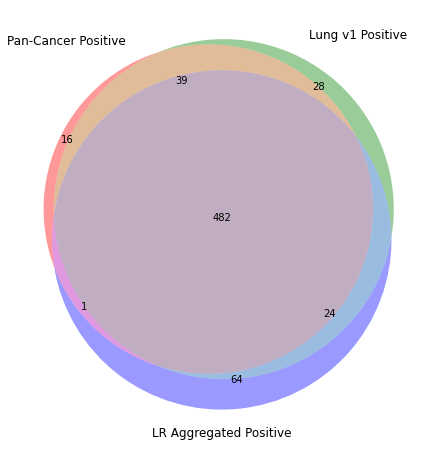

Total sample size used for ISD is 98

Total sample size used for ISD with MB/LR caller info is 98



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Study ID,Patient ID,Customer Sample ID,Sample Time point,plasma_volume_manifest,Sample Type,Cancer Stage,requestcreatedt,bloodcolldate,sample_received_date,cancerother,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,plasma_volume_observed,Batch_ID,new_Cancertype,Cancer_Type_in_Cohort,new_Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_Standardized,call,ldt_reportable,ruo_reportable,variant_comment,Final_RUO_call,on_OMNI,on_G360,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,cn_deletion_sample_comment,cnv_tumor_fraction,hyper_score,on_target_dmr_count,off_target_dmr_count,total_dmr_count,hyper_flag,runid,chry_nonsingleton,contam_vscore,dinucleosome_peak,dm_probes,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_95_lower,methyl_95_upper,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,sample_contamination_pct,sample_coverage_exceptions_ldt,warning,num_fusion_in_homdel,num_somvar_in_homdel,methyl_pos_capture_min,maf
2317,PICI0009,BK15032EP01,A0723584,B00538617,PICI0009.PICI0009-3-1876,PRE-TREATMENT,1,SUCCESS,NaN,SNV,NaN,PIK3CA,3,178952085.0,21.0,H1047R,A>G,c.3140A>G,NM_006218.4,14.60,NaN,somatic,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV55873195,rs121913279,Pathogenic,28691.0,deleterious,NaN,4693.0,16.27,NaN,NaN,Detected,0.083369,6.62,Low,Not Detected,29.016,1.0,0.0,03/14/2023,09/25/2020,12/25/2023,Breast cancer,Not Applicable,Not Applicable,PICI0009,PICI0009.PICI0009-3-1876,BK15032EP01,PRE-TREATMENT,1.0,Plasma,NaN,04/13/2023,09/25/2020,03/14/2023,Breast cancer,NaN,AAAGTATTCG,AAATAGGGTC,Shortened_Targeted_SEQ,EIO_PlateI_F6,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0175_AHKJMMDSX7_PS3C255_AP2.Sirius-1.1.1-RLS,F6,1.0,PS3C-255,Breast cancer,NaN,NaN,NaN,NaN,1.0,1.0,1.0,whitelist_Tier2; cancer_hotspot; ldt_reportable,1.0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,HRD_Pos,0.332700,10.0,0.0,BREAST,49.78998,17.37399,49.78998,-11.69869,17.50793,7,NaN,0.14,7,18,0,18,NaN,231118_A01907_0175_AHKJMMDSX7,0.0,5.0,312.0,18.0,0.00109,3837.0,1.446,0.84,0.04,12.0,12.0,182187.0,0.000027,1.24476,0.02,0.0,NaN,NaN,NaN,1.24476,0.1460
4424,PICI0009,BK15071EP01,A0723557,B00538642,PICI0009.PICI0009-3-1528,6 MONTHS POST 1ST DOSE,1,SUCCESS,NaN,SNV,NaN,PIK3CA,3,178936091.0,10.0,E545K,G>A,c.1633G>A,NM_006218.4,10.84,NaN,somatic,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV55873239,rs104886003,Pathogenic/Likely_pathogenic,28694.0,NaN,NaN,1039.0,10.84,NaN,NaN,Detected,0.090148,11.34,Low,Not Detected,6.292,1.0,0.0,03/14/2023,07/28/2020,12/25/2023,Head and neck squamous cell cancer (HNSCC),Not Applicable,Not Applicable,PICI0009,PICI0009.PICI0009-3-1528,BK15071EP01,6 MONTHS POST 1ST DOSE,1.0,Plasma,NaN,04/13/2023,07/28/2020,03/14/2023,Head and neck squamous cell cancer (HNSCC),NaN,TTCGTGAGAT,ACAAAGCTTC,Shortened_Targeted_SEQ,EIO_PlateI_C3,/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01810_0259_BHKJNMDSX7_PS3C255_AP1.Sirius-1.1.1-RLS,C3,1.0,PS3C-255,Head and neck squamous cell cancer (HNSCC),NaN,NaN

In [12]:
# !pip install matplotlib-venn
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

#select in silico patient samples (MB pos + max-maf > 1% but < 15% + non-TP53 + non-synonymous + whitelist_tier1/2 )

#check positivity conditions on 914 Parker samples
df_parker_clean_1 = df_parker_clean.copy()

df_parker_clean_pan_pos = df_parker_clean_1[df_parker_clean_1["methyl_call_MB_Pan_Cancer"] == 1]
print("Total sample size wtih positive on MB pan-cancer caller is " + str(df_parker_clean_pan_pos.shape[0]) + "\n") 
df_parker_clean_lung_pos = df_parker_clean_1[df_parker_clean_1["methyl_call_MB_Lung_v1"] == 1]
print("Total sample size wtih positive on MB lung v1 caller is " + str(df_parker_clean_lung_pos.shape[0]) + "\n") 
df_parker_clean_LR_agg_pos = df_parker_clean_1[df_parker_clean_1["methyl_call_LR_Aggregated"] == 1]
print("Total sample size wtih positive on LR aggregative caller is " + str(df_parker_clean_LR_agg_pos.shape[0]) + "\n") 

#plot venn diagram to check the overlapping
pan_pos_ids = set(df_parker_clean_pan_pos['GHSampleID'])
lung_pos_ids = set(df_parker_clean_lung_pos['GHSampleID'])
lr_agg_pos_ids = set(df_parker_clean_LR_agg_pos['GHSampleID'])
plt.figure(figsize=(8, 8), facecolor='white')
venn = venn3([pan_pos_ids, lung_pos_ids, lr_agg_pos_ids], ('Pan-Cancer Positive', 'Lung v1 Positive', 'LR Aggregated Positive'))
plt.show()

#select MB pancancer pos samples and max-maf > 1% and non-TP53
df_candidate_1 = df_parker_clean_pan_pos[df_parker_clean_pan_pos["Max_percentage"] > 1] 
#print(df_candidate_1.shape)

#subset the df_candidate_1 samples from the original Parker cohort to access columns "on_G360", "Gene", "Percentage" and "Somatic_status" etc.
sample_list_candi_1 = df_candidate_1.GHSampleID.tolist()
df_parker_candi_1 = df_parker[df_parker.GHSampleID.isin(sample_list_candi_1)]
#print(df_cosmos_MB_rerun_shedding.GHSampleID.nunique())

df_parker_candi_1 = df_parker_candi_1[(df_parker_candi_1["on_G360"] == "Yes") & (df_parker_candi_1["Gene"] != "TP53") & (df_parker_candi_1["Somatic_status"] == "somatic") & (df_parker_candi_1["Percentage"] > 1) & (df_parker_candi_1["Percentage"] < 15) & (df_parker_candi_1["Molecular_consequence"] != "synonymous")]  
df_parker_isd = df_parker_candi_1[df_parker_candi_1["variant_comment"].str.contains("whitelist_Tier1|whitelist_Tier2")]

df_parker_isd = df_parker_isd.loc[df_parker_isd.groupby('GHSampleID')['Percentage'].idxmax()]
df_parker_isd['maf'] = df_parker_isd['Percentage'] / 100
#print(df_parker_isd.GHSampleID.nunique())
print("Total sample size used for ISD is " + str(df_parker_isd.shape[0]) + "\n") 

#select the MB pancancer pos samples and max-maf > 1% and non-TP53
sample_list_candi_2 = df_parker_isd.GHSampleID.tolist()
df_parker_candi_2 = df_parker_clean_pan_pos[df_parker_clean_pan_pos.GHSampleID.isin(sample_list_candi_2)]
print("Total sample size used for ISD with MB/LR caller info is " + str(df_parker_candi_2.shape[0]) + "\n") 

#save the Parker ISD cohort
df_parker_isd.to_csv(f"{work_dir}/df_parker_ISD.csv", index=False) 
df_parker_clean.to_csv(f"{work_dir}/914_parker_samples.csv", index=False) 

df_parker_isd.head()

## Process MRD AV cohort

In [2]:
#Readin samples from MRD AV cohort for LoQ analysis
df_av_loq = pd.read_csv("/ghess/pharma/projects/sirius_pharma/mrd_ist/mb_pan_cancer_s3av/s3av_loq_samples_meta.csv", header = 0) 

print("Total sample size of MRD AV LoQ cohort is " + str(df_av_loq.shape[0]) + "\n") 
print("Total unique sample size of MRD AV LoQ cohort is " + str(df_av_loq.run_sample_id.nunique()) + "\n")
print("Total unique patient sample size of MRD AV LoQ cohort is " + str(df_av_loq.run_sample_id.nunique()) + "\n")
df_av_loq.head()

Total sample size of MRD AV LoQ cohort is 752

Total unique sample size of MRD AV LoQ cohort is 752

Total unique patient sample size of MRD AV LoQ cohort is 752



,run_sample_id,runid,batch_id,well_id,request_id,type,cancer_type,input,target_maf_pct,hyper_residual_count_pos_ctrl,ctrl_cor_frac,methyl_hyper_pos_highcg_count,hotspot_non_singleton_coverage,model_name,methyl_score_LR_Aggregated,methyl_call_LR_Aggregated,pred_type,pred_frac,analysis_version,fc_path,GHSampleID,fc_dir,methyl_score_MB_Lung_v1,threshold_MB_Lung_v1,methyl_call_MB_Lung_v1,methyl_score_MB_Pan_Cancer,threshold_MB_Pan_Cancer,methyl_call_MB_Pan_Cancer
0,KM12_20_15_R1,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,G:1,KM12,cell_line,CRC,15,20.0,52125,1.73833,90472,2271,AGGREGATED,41.59566,1,CRC,0.581942,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,KM12_20_15_R1,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,3.283640,-20.032878,1,6.171024,-20.86299,1
1,H1648_20_15_R1,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,F:2,H1648,cell_line,LUNG,15,20.0,46923,1.92638,88413,2067,AGGREGATED,36.09576,1,LUNG,0.198296,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,H1648_20_15_R1,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,16.635510,-20.032878,1,8.314513,-20.86299,1
2,H2218_20_15_R3,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,A:4,HCC2218,cell_line,BREAST,15,20.0,72597,1.57112,112531,2325,AGGREGATED,43.12771,1,BREAST,0.349826,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,H2218_20_15_R3,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,19.337575,-20.032878,1,13.872918,-20.86299,1
3,H2218_20_15_R2,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,D:4,HCC2218,cell_line,BREAST,15,20.0,63477,1.77381,111680,1936,AGGREGATED,41.78230,1,BREAST,0.343807,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,H2218_20_15_R2,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,18.660438,-20.032878,1,13.275043,-20.86299,1
4,H1648_20_15_R2,230526_A01902_0148_BH3WW3DSX7,S3AV-74-LDT,F:5,H1648,cell_line,LUNG,15,20.0,47053,1.97955,91089,2001,AGGREGATED,35.51657,1,LUNG,0.211016,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0148_BH3WW3DSX7.S3AV_74_LDT_LOD2.Sirius-1.5.0-RC0_20231115-120242,H1648_20_15_R2,/ghds/omni_v2/flowcells//230526_A01902_0148_BH3WW3DSX7.S3AV_74_LDT_LOD2.Sirius-1.5.0-RC0_20231115-120242/sirius_1_5_0_rc0_tar/,16.718688,-20.032878,1,7.884320,-20.86299,1


In [3]:
#select ISD analysis from MRD AV LoQ analysis data (section 9.6.4 of this report: https://docs.google.com/document/d/16z-1MJ1ROeMogk4_wtpJ3g_rShoCvlEj/edit)

#check positivity conditions on 752 MRD AV LoQ analysis samples
df_av_loq_1 = df_av_loq.copy()

df_av_loq_pan_pos = df_av_loq_1[df_av_loq_1["methyl_call_MB_Pan_Cancer"] == 1]
print("Total sample size wtih positive on MB pan-cancer caller is " + str(df_av_loq_pan_pos.shape[0]) + "\n") 

#select MB pancancer pos samples and max-maf > 1%
df_av_loq_isd = df_av_loq_1[df_av_loq_1["target_maf_pct"] >= 1] 
print("Total sample size used for ISD from MRD AV LoQ samples is " + str(df_av_loq_isd.shape[0]) + "\n") 

df_av_loq_isd["maf"] = df_av_loq_isd["target_maf_pct"] / 100
df_av_loq_isd.head()

Total sample size wtih positive on MB pan-cancer caller is 706

Total sample size used for ISD from MRD AV LoQ samples is 136



,run_sample_id,runid,batch_id,well_id,request_id,type,cancer_type,input,target_maf_pct,hyper_residual_count_pos_ctrl,ctrl_cor_frac,methyl_hyper_pos_highcg_count,hotspot_non_singleton_coverage,model_name,methyl_score_LR_Aggregated,methyl_call_LR_Aggregated,pred_type,pred_frac,analysis_version,fc_path,GHSampleID,fc_dir,methyl_score_MB_Lung_v1,threshold_MB_Lung_v1,methyl_call_MB_Lung_v1,methyl_score_MB_Pan_Cancer,threshold_MB_Pan_Cancer,methyl_call_MB_Pan_Cancer,maf
0,KM12_20_15_R1,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,G:1,KM12,cell_line,CRC,15,20.0,52125,1.73833,90472,2271,AGGREGATED,41.59566,1,CRC,0.581942,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,KM12_20_15_R1,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,3.283640,-20.032878,1,6.171024,-20.86299,1,0.2
1,H1648_20_15_R1,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,F:2,H1648,cell_line,LUNG,15,20.0,46923,1.92638,88413,2067,AGGREGATED,36.09576,1,LUNG,0.198296,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,H1648_20_15_R1,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,16.635510,-20.032878,1,8.314513,-20.86299,1,0.2
2,H2218_20_15_R3,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,A:4,HCC2218,cell_line,BREAST,15,20.0,72597,1.57112,112531,2325,AGGREGATED,43.12771,1,BREAST,0.349826,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,H2218_20_15_R3,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,19.337575,-20.032878,1,13.872918,-20.86299,1,0.2
3,H2218_20_15_R2,230526_A01902_0149_AH3W3LDSX7,S3AV-74-LDT,D:4,HCC2218,cell_line,BREAST,15,20.0,63477,1.77381,111680,1936,AGGREGATED,41.78230,1,BREAST,0.343807,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518,H2218_20_15_R2,/ghds/omni_v2/flowcells//230526_A01902_0149_AH3W3LDSX7.S3AV_74_LDT_LOD1.Sirius-1.5.0-RC0_20231115-115518/sirius_1_5_0_rc0_tar/,18.660438,-20.032878,1,13.275043,-20.86299,1,0.2
4,H1648_20_15_R2,230526_A01902_0148_BH3WW3DSX7,S3AV-74-LDT,F:5,H1648,cell_line,LUNG,15,20.0,47053,1.97955,91089,2001,AGGREGATED,35.51657,1,LUNG,0.211016,Sirius-1.5.0-RC0,/ghds/omni_v2/flowcells//230526_A01902_0148_BH3WW3DSX7.S3AV_74_LDT_LOD2.Sirius-1.5.0-RC0_20231115-120242,H1648_20_15_R2,/ghds/omni_v2/flowcells//230526_A01902_0148_BH3WW3DSX7.S3AV_74_LDT_LOD2.Sirius-1.5.0-RC0_20231115-120242/sirius_1_5_0_rc0_tar/,16.718688,-20.032878,1,7.884320,-20.86299,1,0.2


In [4]:
#Readin samples from MRD AV cohort for Accuracy analysis
df_av_acc = pd.read_csv("/ghess/pharma/projects/sirius_pharma/mrd_ist/mb_pan_cancer_s3av/s3av_accuracy_samples_meta.csv", header = 0) 

print("Total sample size of MRD AV Accuracy cohort is " + str(df_av_acc.shape[0]) + "\n") 
print("Total unique sample size of MRD Accuracy LoQ cohort is " + str(df_av_acc.run_sample_id.nunique()) + "\n")
print("Total unique patient sample size of MRD Accuracy LoQ cohort is " + str(df_av_acc.run_sample_id.nunique()) + "\n")
df_av_acc.head()

Total sample size of MRD AV Accuracy cohort is 266

Total unique sample size of MRD Accuracy LoQ cohort is 266

Total unique patient sample size of MRD Accuracy LoQ cohort is 266



,run_sample_id,runid,cancertype,cancertype_8,hyper_residual_count_pos_ctrl,sample_pass,methyl_call_LR_Aggregated,pred_frac,pred_type,max_maf_AI_TF,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_variant_comment,max_maf_gene_cn,AI_TF,rms,fc_dir,methyl_score_MB_Lung_v1,threshold_MB_Lung_v1,methyl_call_MB_Lung_v1,methyl_score_MB_Pan_Cancer,threshold_MB_Pan_Cancer,methyl_call_MB_Pan_Cancer,TF_group
0,Accu_HRD10_4507,230502_A00274_0841_BH3V72DSX7,Colorectal adenocarcinoma,Colorectal adenocarcinoma,84383,True,1,0.425798,CRC,0.710300,0.7103,KRAS,G12C,whitelist_Tier1; drug_resistance; snp called in gene; somatic call above 70%; ldt_reportable,NaN,0.608656,19.466440,/ghds/omni_v2/flowcells/230502_A00274_0841_BH3V72DSX7.S3AV58LDT_AP3.Sirius-1.5.0-RC0_20231115-153507/sirius_1_5_0_rc0_tar/,6.367888,-20.032878,1,13.195671,-20.86299,1,High TF
1,Accu_HRD1_3057,230502_A00274_0840_AH3TY7DSX7,Lung adenocarcinoma,Lung adenocarcinoma,85022,True,1,0.213306,BREAST,0.537867,0.2500,LRP1B,H1972H,somatic pval; distbin vs dectree,NaN,0.537867,17.448322,/ghds/omni_v2/flowcells/230502_A00274_0840_AH3TY7DSX7.S3AV58LDT_AP1.Sirius-1.5.0-RC0_20231115-152826/sirius_1_5_0_rc0_tar/,5.251715,-20.032878,1,-0.638192,-20.86299,1,High TF
2,Accu_HRD3_4608,230502_A00274_0840_AH3TY7DSX7,Colorectal adenocarcinoma,Colorectal adenocarcinoma,100608,True,1,0.409299,CRC,0.598351,0.5273,KRAS,G12D,whitelist_Tier1; drug_resistance; snp called in gene; whitelist with germline distbin; ldt_reportable,NaN,0.598351,19.249490,/ghds/omni_v2/flowcells/230502_A00274_0840_AH3TY7DSX7.S3AV58LDT_AP1.Sirius-1.5.0-RC0_20231115-152826/sirius_1_5_0_rc0_tar/,5.458705,-20.032878,1,11.448587,-20.86299,1,High TF
3,Accu_HRD6_4405,230502_A00274_0840_AH3TY7DSX7,Breast Carcinoma,Breast Carcinoma,81124,True,1,0.281355,BREAST,0.658800,0.6588,AKT1,E17K,whitelist_Tier1; cancer_hotspot; ldt_reportable,NaN,0.460855,15.295600,/ghds/omni_v2/flowcells/230502_A00274_0840_AH3TY7DSX7.S3AV58LDT_AP1.Sirius-1.5.0-RC0_20231115-152826/sirius_1_5_0_rc0_tar/,15.363882,-20.032878,1,14.242923,-20.86299,1,High TF
4,Accu_HRD8_4447,230502_A00274_0840_AH3TY7DSX7,Carcinoma of unknown primary (CUP),other,76584,True,1,0.231049,LUNG,0.200174,NaN,NaN,NaN,NaN,NaN,0.200174,9.397147,/ghds/omni_v2/flowcells/230502_A00274_0840_AH3TY7DSX7.S3AV58LDT_AP1.Sirius-1.5.0-RC0_20231115-152826/sirius_1_5_0_rc0_tar/,6.920523,-20.032878,1,-1.442039,-20.86299,1,High TF


In [5]:
#select ISD analysis from MRD AV cohort for Accuracy analysis samples (MB pos + max-maf > 1% + whitelist_tier1/2 )

#check positivity conditions on MRD AV cohort for Accuracy analysis samples
df_av_acc_1 = df_av_acc.copy()

df_av_acc_pan_pos = df_av_acc_1[df_av_acc_1["methyl_call_MB_Pan_Cancer"] == 1]
print("Total MRD AV Accuracy cohort sample size wtih positive on MB pan-cancer caller is " + str(df_av_acc_pan_pos.shape[0]) + "\n") 

#select MB pancancer pos samples and max_maf_AI_TF > 1%
df_av_acc_candidate_1 = df_av_acc_pan_pos[df_av_acc_pan_pos["max_maf_AI_TF"] >= 0.01] 
# print(df_av_acc_candidate_1.shape)

#subset the df_av_acc_candidate_1 samples for genes in whitelist tier1 and tier2
df_av_acc_candidate_1 = df_av_acc_candidate_1.dropna(subset=["max_maf_variant_comment"])
df_av_acc_isd = df_av_acc_candidate_1[df_av_acc_candidate_1["max_maf_variant_comment"].str.contains("whitelist_Tier1|whitelist_Tier2")]
print("Total sample size used for ISD from MRD AV Accuracy samples is " + str(df_av_acc_isd.shape[0]) + "\n") 

df_av_acc_isd.head()

Total MRD AV Accuracy cohort sample size wtih positive on MB pan-cancer caller is 258

Total sample size used for ISD from MRD AV Accuracy samples is 106



,run_sample_id,runid,cancertype,cancertype_8,hyper_residual_count_pos_ctrl,sample_pass,methyl_call_LR_Aggregated,pred_frac,pred_type,max_maf_AI_TF,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_variant_comment,max_maf_gene_cn,AI_TF,rms,fc_dir,methyl_score_MB_Lung_v1,threshold_MB_Lung_v1,methyl_call_MB_Lung_v1,methyl_score_MB_Pan_Cancer,threshold_MB_Pan_Cancer,methyl_call_MB_Pan_Cancer,TF_group
0,Accu_HRD10_4507,230502_A00274_0841_BH3V72DSX7,Colorectal adenocarcinoma,Colorectal adenocarcinoma,84383,True,1,0.425798,CRC,0.710300,0.7103,KRAS,G12C,whitelist_Tier1; drug_resistance; snp called in gene; somatic call above 70%; ldt_reportable,NaN,0.608656,19.466440,/ghds/omni_v2/flowcells/230502_A00274_0841_BH3V72DSX7.S3AV58LDT_AP3.Sirius-1.5.0-RC0_20231115-153507/sirius_1_5_0_rc0_tar/,6.367888,-20.032878,1,13.195671,-20.86299,1,High TF
2,Accu_HRD3_4608,230502_A00274_0840_AH3TY7DSX7,Colorectal adenocarcinoma,Colorectal adenocarcinoma,100608,True,1,0.409299,CRC,0.598351,0.5273,KRAS,G12D,whitelist_Tier1; drug_resistance; snp called in gene; whitelist with germline distbin; ldt_reportable,NaN,0.598351,19.249490,/ghds/omni_v2/flowcells/230502_A00274_0840_AH3TY7DSX7.S3AV58LDT_AP1.Sirius-1.5.0-RC0_20231115-152826/sirius_1_5_0_rc0_tar/,5.458705,-20.032878,1,11.448587,-20.86299,1,High TF
3,Accu_HRD6_4405,230502_A00274_0840_AH3TY7DSX7,Breast Carcinoma,Breast Carcinoma,81124,True,1,0.281355,BREAST,0.658800,0.6588,AKT1,E17K,whitelist_Tier1; cancer_hotspot; ldt_reportable,NaN,0.460855,15.295600,/ghds/omni_v2/flowcells/230502_A00274_0840_AH3TY7DSX7.S3AV58LDT_AP1.Sirius-1.5.0-RC0_20231115-152826/sirius_1_5_0_rc0_tar/,15.363882,-20.032878,1,14.242923,-20.86299,1,High TF
7,CA_298572,230511_A01902_0136_AH3V57DSX7,Pancreatic ductal adenocarcinoma,Pancreatic ductal adenocarcinoma,40448,True,1,0.263147,LUNG,0.468695,0.3264,KRAS,G12V,whitelist_Tier1; drug_resistance; snp called in gene; ldt_reportable,NaN,0.468695,15.515254,/ghds/omni_v2/flowcells/230511_A01902_0136_AH3V57DSX7.S3AV_69_LDT_ACC1.Sirius-1.5.0-RC0_20231118-113026/sirius_1_5_0_rc0_tar/,10.028271,-20.032878,1,12.314128,-20.86299,1,High TF
9,CA_302203,230511_A01902_0136_AH3V57DSX7,Breast Carcinoma,Breast Carcinoma,46966,True,1,0.399220,BREAST,0.327100,0.3271,PIK3CA,E545K,whitelist_Tier2; drug_resistance; ldt_reportable,NaN,0.250395,11.271805,/ghds/omni_v2/flowcells/230511_A01902_0136_AH3V57DSX7.S3AV_69_LDT_ACC1.Sirius-1.5.0-RC0_20231118-113026/sirius_1_5_0_rc0_tar/,16.198209,-20.032878,1,17.447927,-20.86299,1,High TF


# Generate MB callers outputs for Parker cohort

## MB lung v1 caller on ISD Parker samples

In [14]:
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_lung_v1_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
    region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv' 
    control_region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv' 
    lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv' 

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{workdir}/MB_lung_v1_parker_jobs/MB_call_{run_sample_id}.job" 
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={workdir}/MB_lung_v1_parker_jobs/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--residual-molecule-file {mbd_residual_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {workdir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [15]:
#run the function to generate all the MB Lung v1 caller ouputs
run_mb_lung_v1_caller_wrapper_slurm(df_parker_candi_1, 
                      "/ghds/pharma/projects/sirius_pharma/mrd_ist/smc_New_MB/lung_candidate_model.mafband_0.01_0.1.devHyper.09-25-23.tsv", 
                      f"{work_dir}/MB_lung_v1_parker_output")

Submitted batch job 71087127
Submitted batch job 71087128
Submitted batch job 71087129
Submitted batch job 71087130
Submitted batch job 71087131
Submitted batch job 71087132
Submitted batch job 71087133
Submitted batch job 71087134
Submitted batch job 71087135
Submitted batch job 71087136
Submitted batch job 71087137
Submitted batch job 71087138
Submitted batch job 71087139
Submitted batch job 71087140
Submitted batch job 71087141
Submitted batch job 71087142
Submitted batch job 71087143
Submitted batch job 71087144
Submitted batch job 71087145
Submitted batch job 71087146
Submitted batch job 71087147
Submitted batch job 71087148
Submitted batch job 71087149
Submitted batch job 71087150
Submitted batch job 71087151
Submitted batch job 71087152
Submitted batch job 71087153
Submitted batch job 71087154
Submitted batch job 71087155
Submitted batch job 71087156
Submitted batch job 71087157
Submitted batch job 71087158
Submitted batch job 71087159
Submitted batch job 71087160
Submitted batc

## MB pancancer caller on ISD Parker samples

In [12]:
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_pancancer_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
    region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv' 
    control_region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv' 
    lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv' 

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{workdir}/MB_pancancer_parker_jobs/MB_call_{run_sample_id}.job" 
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={workdir}/MB_pancancer_parker_jobs/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--residual-molecule-file {mbd_residual_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {workdir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [13]:
#run the function to generate all the MB pancancer caller ouputs
run_mb_pancancer_caller_wrapper_slurm(df_parker_candi_1, 
                      "/home/byounggreenwald/Pancancer_v2.5_single_isd_filter_warmstart.model_file.98_spec.set_on_s3.tsv", 
                      f"{work_dir}/MB_pancancer_parker_output")

Submitted batch job 71086827
Submitted batch job 71086828
Submitted batch job 71086829
Submitted batch job 71086830
Submitted batch job 71086831
Submitted batch job 71086832
Submitted batch job 71086833
Submitted batch job 71086834
Submitted batch job 71086835
Submitted batch job 71086836
Submitted batch job 71086837
Submitted batch job 71086838
Submitted batch job 71086839
Submitted batch job 71086840
Submitted batch job 71086841
Submitted batch job 71086842
Submitted batch job 71086843
Submitted batch job 71086844
Submitted batch job 71086845
Submitted batch job 71086846
Submitted batch job 71086847
Submitted batch job 71086848
Submitted batch job 71086849
Submitted batch job 71086850
Submitted batch job 71086851
Submitted batch job 71086852
Submitted batch job 71086853
Submitted batch job 71086854
Submitted batch job 71086855
Submitted batch job 71086856
Submitted batch job 71086857
Submitted batch job 71086858
Submitted batch job 71086859
Submitted batch job 71086860
Submitted batc

# LoD simulation

## simulation for Parker samples

In [14]:
#load cancer-free samples from MRD AV project
mrd_av = pd.read_table("/ghds/projects/omni_v2/users/kquinn/mrd_av_analysis/MRD_AV_Manifest_With_QC_And_Calls_CRC_May16.tsv")
print(mrd_av.Cancertype.value_counts())

cancer_free_df_ori = mrd_av[(mrd_av.Cancertype=="HD")]
cancer_free_df_ori["run_sample_id"] = cancer_free_df_ori["run_sample_ID"]

cancer_free_df_ori[["run_sample_id", "Cancertype", "NSC", "hyper_residual_count_pos_ctrl","fc_dir"]].to_csv(f"{work_dir}/cancer_free_meta.tsv", sep="\t", index=False)
cancer_free_df = pd.read_table(f"{work_dir}/cancer_free_meta.tsv")
cancer_free_df.head()

CRC    354
HD      24
Name: Cancertype, dtype: int64


,run_sample_id,Cancertype,NSC,hyper_residual_count_pos_ctrl,fc_dir
0,HD_03002,HD,537.0,24074.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
1,HD_79319,HD,1211.0,35081.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
2,HD_03003,HD,823.0,31958.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
3,HD_01734,HD,1166.0,42587.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
4,HD_01493,HD,1561.0,61172.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/


In [13]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for MB model (2.7k DMRs)
#The titrations (target_maf) and output folder need to be defined within run_hyper_titraion_parker_MB_pancancer_01082024.py. 
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  

mb_caller_result_folder = f"{work_dir}/MB_pancancer_parker_output"

for index, crc_row in df_parker_isd.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 
    msre_mr_file_df = pd.read_table(msre_mr_file) 
    CRC_pos_ctrl_value = msre_mr_file_df['hyper_residual_count_pos_ctrl'].iloc[0]

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        job_file = f"{work_dir}/Parker_MB_pancancer_simu_job/MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={work_dir}/Parker_MB_pancancer_simu_job/MB_simu_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            # Note: The output folder needs to be hardcoded in run_hyper_titraion_parker_MB_pancancer_01082024.py!
            # Note: warnings remaining, check the log
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_parker_MB_pancancer_01082024.py "
                f"--CRC_sample_id {crc_row['GHSampleID']} --CRC_file {msre_mr_file} "
                f"--CRC_pos_ctrl {int(CRC_pos_ctrl_value)} --CF_sample_id {cf_row['run_sample_id']} "
                f"--CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} --CRC_maf {crc_row['maf']}\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

Submitted batch job 71093548
Submitted batch job 71093549
Submitted batch job 71093550
Submitted batch job 71093551
Submitted batch job 71093552
Submitted batch job 71093553
Submitted batch job 71093554
Submitted batch job 71093555
Submitted batch job 71093556
Submitted batch job 71093560
Submitted batch job 71093561
Submitted batch job 71093562
Submitted batch job 71093563
Submitted batch job 71093564
Submitted batch job 71093565
Submitted batch job 71093566
Submitted batch job 71093567
Submitted batch job 71093568
Submitted batch job 71093569
Submitted batch job 71093570
Submitted batch job 71093571
Submitted batch job 71093572
Submitted batch job 71093573
Submitted batch job 71093574
Submitted batch job 71093575
Submitted batch job 71093576
Submitted batch job 71093577
Submitted batch job 71093578
Submitted batch job 71093579
Submitted batch job 71093580
Submitted batch job 71093581
Submitted batch job 71093582
Submitted batch job 71093583
Submitted batch job 71093584
Submitted batc

In [15]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for LR model (27.7k DMRs)
#The titrations (target_maf) and output folder NO need to be defined within run_hyper_titraion_parker_LR_01082024.py from Che-yu
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  
cf_fc_dict = {
    "/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius-1.1.1-RLS_20231031-113357/",
    "/ghds/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius-1.1.1-RLS_20231031-113645/"
}

for index, row in df_parker_isd.iterrows():
    fc_dir = row['fc_dir']
    run_sample_id = row["GHSampleID"]
    pos_control = row["methyl_hyper_pos_highcg_count"]
    
    msre_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_lr_feature.tsv"
    if not os.path.exists(msre_file):
        print("Error: " + run_sample_id)
        print(msre_file)
        
    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_fc_dir = cf_fc_dict[cf_row["fc_dir"]]
        cf_file = f"{cf_fc_dir}/{cf_row['run_sample_id']}/{cf_row['run_sample_id']}.msre_lr_feature.tsv"
        job_file = f"{work_dir}/Parker_LR_simu_job/LR_simu_{run_sample_id}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{row['GHSampleID']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={work_dir}/Parker_LR_simu_job/LR_simu_{run_sample_id}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_parker_LR_01082024.py "
                f"--CRC_sample_id {run_sample_id} --CRC_file {msre_file} --CRC_pos_ctrl {int(pos_control)} "
                f"--CF_sample_id {cf_row['run_sample_id']} --CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} "
                f"--CRC_maf {row['maf']} --output_folder {work_dir}/Parker_LR_hyper_simu\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

Submitted batch job 71100774
Submitted batch job 71100775
Submitted batch job 71100776
Submitted batch job 71100777
Submitted batch job 71100778
Submitted batch job 71100779
Submitted batch job 71100780
Submitted batch job 71100781
Submitted batch job 71100782
Submitted batch job 71100783
Submitted batch job 71100784
Submitted batch job 71100785
Submitted batch job 71100786
Submitted batch job 71100787
Submitted batch job 71100788
Submitted batch job 71100789
Submitted batch job 71100790
Submitted batch job 71100791
Submitted batch job 71100792
Submitted batch job 71100793
Submitted batch job 71100794
Submitted batch job 71100795
Submitted batch job 71100796
Submitted batch job 71100797
Submitted batch job 71100798
Submitted batch job 71100799
Submitted batch job 71100800
Submitted batch job 71100801
Submitted batch job 71100802
Submitted batch job 71100803
Submitted batch job 71100804
Submitted batch job 71100805
Submitted batch job 71100806
Submitted batch job 71100807
Submitted batc

## simulation for MRD AV samples

### MRD AV LoQ analysis samples

In [22]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for MB model (2.7k DMRs)
#The titrations (target_maf) and output folder need to be defined within run_hyper_titraion_MRD_AV_LoQ_MB_pancancer_01082024.py. 
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  

mb_caller_result_folder = f"/ghess/pharma/projects/sirius_pharma/mrd_ist/mb_pan_cancer_s3av/mb_pancancer_run"

for index, crc_row in df_av_loq_isd.iterrows():
    run_sample_id = crc_row["run_sample_id"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 
    msre_mr_file_df = pd.read_table(msre_mr_file) 
    CRC_pos_ctrl_value = msre_mr_file_df['hyper_residual_count_pos_ctrl'].iloc[0]

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        job_file = f"{work_dir}/MRD_AV_LoQ_simu_job/MB_simu_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={work_dir}/MRD_AV_LoQ_simu_job/MB_simu_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            # Note: The output folder needs to be hardcoded in run_hyper_titraion_MRD_AV_LoQ_MB_pancancer_01082024.py!
            # Note: warnings remaining, check the log
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_MRD_AV_LoQ_MB_pancancer_01082024.py "
                f"--CRC_sample_id {crc_row['run_sample_id']} --CRC_file {msre_mr_file} "
                f"--CRC_pos_ctrl {int(CRC_pos_ctrl_value)} --CF_sample_id {cf_row['run_sample_id']} "
                f"--CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} --CRC_maf {crc_row['maf']}\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

Submitted batch job 71156326
Submitted batch job 71156327
Submitted batch job 71156328
Submitted batch job 71156329
Submitted batch job 71156330
Submitted batch job 71156331
Submitted batch job 71156332
Submitted batch job 71156333
Submitted batch job 71156334
Submitted batch job 71156335
Submitted batch job 71156336
Submitted batch job 71156337
Submitted batch job 71156338
Submitted batch job 71156339
Submitted batch job 71156340
Submitted batch job 71156341
Submitted batch job 71156342
Submitted batch job 71156343
Submitted batch job 71156344
Submitted batch job 71156345
Submitted batch job 71156346
Submitted batch job 71156347
Submitted batch job 71156348
Submitted batch job 71156349
Submitted batch job 71156350
Submitted batch job 71156351
Submitted batch job 71156352
Submitted batch job 71156353
Submitted batch job 71156354
Submitted batch job 71156355
Submitted batch job 71156356
Submitted batch job 71156357
Submitted batch job 71156358
Submitted batch job 71156359
Submitted batc

In [10]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for LR model (27.7k DMRs)
#The titrations (target_maf) and output folder NO need to be defined within run_hyper_titraion_parker_LR_01082024.py from Che-yu
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  
cf_fc_dict = {
    "/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius-1.1.1-RLS_20231031-113357/",
    "/ghds/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius-1.1.1-RLS_20231031-113645/"
}

for index, row in df_av_loq_isd.iterrows():
    fc_dir = row['fc_dir']
    run_sample_id = row["run_sample_id"]
    pos_control = row["methyl_hyper_pos_highcg_count"]
    
    msre_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_lr_feature.tsv"
    if not os.path.exists(msre_file):
        print("Error: " + run_sample_id)
        print(msre_file)
    
    #Create the output folders
    simu_job_dir = f"{work_dir}/MRD_AV_LoQ_LR_simu_job"
    simu_file_dir = f"{work_dir}/MRD_AV_LoD_LR_hyper_simu"
    # Create the folder if it doesn't exist
    if not os.path.exists(simu_job_dir):
        os.makedirs(simu_job_dir)
    if not os.path.exists(simu_file_dir):
        os.makedirs(simu_file_dir)
    
    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_fc_dir = cf_fc_dict[cf_row["fc_dir"]]
        cf_file = f"{cf_fc_dir}/{cf_row['run_sample_id']}/{cf_row['run_sample_id']}.msre_lr_feature.tsv"
        job_file = f"{work_dir}/MRD_AV_LoQ_LR_simu_job/LR_simu_{run_sample_id}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{row['run_sample_id']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={work_dir}/MRD_AV_LoQ_LR_simu_job/LR_simu_{run_sample_id}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_parker_LR_01082024.py "
                f"--CRC_sample_id {run_sample_id} --CRC_file {msre_file} --CRC_pos_ctrl {int(pos_control)} "
                f"--CF_sample_id {cf_row['run_sample_id']} --CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} "
                f"--CRC_maf {row['maf']} --output_folder {work_dir}/MRD_AV_LoD_LR_hyper_simu\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

Submitted batch job 71171221
Submitted batch job 71171222
Submitted batch job 71171223
Submitted batch job 71171224
Submitted batch job 71171225
Submitted batch job 71171226
Submitted batch job 71171227
Submitted batch job 71171228
Submitted batch job 71171229
Submitted batch job 71171230
Submitted batch job 71171231
Submitted batch job 71171232
Submitted batch job 71171233
Submitted batch job 71171234
Submitted batch job 71171235
Submitted batch job 71171236
Submitted batch job 71171237
Submitted batch job 71171238
Submitted batch job 71171239
Submitted batch job 71171240
Submitted batch job 71171241
Submitted batch job 71171242
Submitted batch job 71171243
Submitted batch job 71171244
Submitted batch job 71171245
Submitted batch job 71171246
Submitted batch job 71171247
Submitted batch job 71171248
Submitted batch job 71171249
Submitted batch job 71171250
Submitted batch job 71171251
Submitted batch job 71171252
Submitted batch job 71171253
Submitted batch job 71171254
Submitted batc

### MRD AV Accuracy analysis samples

In [25]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for MB model (2.7k DMRs)
#The titrations (target_maf) and output folder need to be defined within run_hyper_titraion_MRD_AV_Accuracy_MB_pancancer_01082024.py. 
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  

mb_caller_result_folder = f"/ghess/pharma/projects/sirius_pharma/mrd_ist/mb_pan_cancer_s3av/mb_pancancer_run_accuracy"

for index, crc_row in df_av_acc_isd.iterrows():
    run_sample_id = crc_row["run_sample_id"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 
    msre_mr_file_df = pd.read_table(msre_mr_file) 
    CRC_pos_ctrl_value = msre_mr_file_df['hyper_residual_count_pos_ctrl'].iloc[0]

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        job_file = f"{work_dir}/MRD_AV_Accuracy_simu_job/MB_simu_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={work_dir}/MRD_AV_Accuracy_simu_job/MB_simu_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            # Note: The output folder needs to be hardcoded in run_hyper_titraion_MRD_AV_Accuracy_MB_pancancer_01082024.py!
            # Note: warnings remaining, check the log
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_MRD_AV_Accuracy_MB_pancancer_01082024.py "
                f"--CRC_sample_id {crc_row['run_sample_id']} --CRC_file {msre_mr_file} "
                f"--CRC_pos_ctrl {int(CRC_pos_ctrl_value)} --CF_sample_id {cf_row['run_sample_id']} "
                f"--CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} --CRC_maf {crc_row['max_maf_AI_TF']}\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

Submitted batch job 71162134
Submitted batch job 71162135
Submitted batch job 71162136
Submitted batch job 71162137
Submitted batch job 71162138
Submitted batch job 71162139
Submitted batch job 71162140
Submitted batch job 71162141
Submitted batch job 71162142
Submitted batch job 71162143
Submitted batch job 71162144
Submitted batch job 71162145
Submitted batch job 71162146
Submitted batch job 71162147
Submitted batch job 71162148
Submitted batch job 71162149
Submitted batch job 71162150
Submitted batch job 71162151
Submitted batch job 71162152
Submitted batch job 71162153
Submitted batch job 71162154
Submitted batch job 71162155
Submitted batch job 71162156
Submitted batch job 71162157
Submitted batch job 71162158
Submitted batch job 71162159
Submitted batch job 71162160
Submitted batch job 71162161
Submitted batch job 71162162
Submitted batch job 71162163
Submitted batch job 71162164
Submitted batch job 71162165
Submitted batch job 71162166
Submitted batch job 71162167
Submitted batc

In [29]:
#Simulate/shuffle patient samples with cancer-free samples to different titrations for LR model (27.7k DMRs)
#The titrations (target_maf) and output folder NO need to be defined within run_hyper_titraion_parker_LR_01082024.py from Che-yu
#Each simulated sample will have 15 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]  
cf_fc_dict = {
    "/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius-1.1.1-RLS_20231031-113357/",
    "/ghds/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius-1.1.1-RLS_20231031-113645/"
}

for index, row in df_av_acc_isd.iterrows():
    fc_dir = row['fc_dir']
    run_sample_id = row["run_sample_id"]
    
    msre_lr_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_lr_call.hdr.tsv" 
    msre_lr_file_df = pd.read_table(msre_lr_file) 
    pos_control = msre_lr_file_df['hyper_residual_count_pos_ctrl'].iloc[0]
        
    msre_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_lr_feature.tsv"
    if not os.path.exists(msre_file):
        print("Error: " + run_sample_id)
        print(msre_file)
    
    #Create the output folders
    simu_job_dir = f"{work_dir}/MRD_AV_Accuracy_LR_simu_job"
    simu_file_dir = f"{work_dir}/MRD_AV_Accuracy_LR_hyper_simu"
    # Create the folder if it doesn't exist
    if not os.path.exists(simu_job_dir):
        os.makedirs(simu_job_dir)
    if not os.path.exists(simu_file_dir):
        os.makedirs(simu_file_dir)
    
    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_fc_dir = cf_fc_dict[cf_row["fc_dir"]]
        cf_file = f"{cf_fc_dir}/{cf_row['run_sample_id']}/{cf_row['run_sample_id']}.msre_lr_feature.tsv"
        job_file = f"{simu_job_dir}/LR_simu_{run_sample_id}_{cf_row['run_sample_id']}.job" 
        
        shebang_content = (
            "#!/bin/bash\n"
            f"#SBATCH --job-name=MB_simu_{row['run_sample_id']}_{cf_row['run_sample_id']}\n"
            "#SBATCH --nodes=1\n"
            "#SBATCH --ntasks=1\n"
            "#SBATCH --cpus-per-task=1\n"
            "#SBATCH --mem=20gb\n"
            "#SBATCH --time=00:10:00\n"
            f"#SBATCH --output={simu_job_dir}/LR_simu_{run_sample_id}_{cf_row['run_sample_id']}.log\n\n"
        )

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(
                f"python3 {work_dir}/run_hyper_titraion_parker_LR_01082024.py "
                f"--CRC_sample_id {run_sample_id} --CRC_file {msre_file} --CRC_pos_ctrl {int(pos_control)} "
                f"--CF_sample_id {cf_row['run_sample_id']} --CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} "
                f"--CRC_maf {row['max_maf_AI_TF']} --output_folder {simu_file_dir}\n"
            )

        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

print("Done")

Submitted batch job 71167942
Submitted batch job 71167943
Submitted batch job 71167944
Submitted batch job 71167945
Submitted batch job 71167946
Submitted batch job 71167947
Submitted batch job 71167948
Submitted batch job 71167949
Submitted batch job 71167950
Submitted batch job 71167951
Submitted batch job 71167952
Submitted batch job 71167953
Submitted batch job 71167954
Submitted batch job 71167955
Submitted batch job 71167956
Submitted batch job 71167957
Submitted batch job 71167958
Submitted batch job 71167959
Submitted batch job 71167960
Submitted batch job 71167961
Submitted batch job 71167962
Submitted batch job 71167963
Submitted batch job 71167964
Submitted batch job 71167965
Submitted batch job 71167966
Submitted batch job 71167967
Submitted batch job 71167968
Submitted batch job 71167969
Submitted batch job 71167970
Submitted batch job 71167971
Submitted batch job 71167972
Submitted batch job 71167973
Submitted batch job 71167974
Submitted batch job 71167975
Submitted batc

## MB/LR aggregated score generation on simulated samples

### Parker samples

In [7]:
#The adj_intercept of each LR caller was found here: https://github.com/guardant/bip-products/blob/master/models/Sirius/status-model.param.tsv
#The function to calculate LR aggregated score
def calculate_LR_aggregated_score(msre_lr_feature, hyper_residual_count_pos_ctrl):
    df = pd.read_table(msre_lr_feature)
    df["norm_count"] = df["num_molecules"]/hyper_residual_count_pos_ctrl
    df["log_norm"] = np.log10(df["norm_count"]+1e-6)
    
    #LR breast
    df["new_score"] = (df["log_norm"]-df["BREAST_center"])*df["BREAST_coef"]/df["BREAST_scale"]
    breast_score = df["new_score"].sum()-4.9235781074842215
    #LR CRC
    df["new_score"] = (df["log_norm"]-df["CRC_center"])*df["CRC_coef"]/df["CRC_scale"]
    crc_score = df["new_score"].sum()-3.93313414380353
    #LR Lung
    df["new_score"] = (df["log_norm"]-df["LUNG_center"])*df["LUNG_coef"]/df["LUNG_scale"]
    lung_score = df["new_score"].sum()-4.770697644394463
    #LR bladder
    df["new_score"] = (df["log_norm"]-df["BLADDER_center"])*df["BLADDER_coef"]/df["BLADDER_scale"]
    bladder_score = df["new_score"].sum()-4.671234217067342
    
    return max(breast_score, crc_score, lung_score, bladder_score)

calculate_LR_aggregated_score("/ghds/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/231118_A01907_0174_BHKJHYDSX7_PS3C255_AP3.Sirius-1.1.1-RLS/B00538703/B00538703.msre_lr_feature.tsv", 61566)

37.192495623162706

In [7]:
#The function to calculate MB Lung v1 score
mb_lung_v1_model_coef = pd.read_table("/ghsfa/projects/pharma/projects/sirius_pharma/mrd_ist/smc_New_MB/lung_candidate_model.mafband_0.01_0.1.devHyper.09-25-23.tsv")

def calculate_MB_lung_v1_score(msre_file, mb_lung_v1_model_coef):
    msre_df = pd.read_table(msre_file)
    msre_df["region_score"] = np.log10(msre_df["hyper_residual_count"]/msre_df["hyper_residual_count_pos_ctrl"] + 1e-5)
    v6_score_df = (
        msre_df
         .merge(mb_lung_v1_model_coef, on='region_id', how='left')
        .groupby(["run_sample_id", "runid"])
        .apply(lambda x: (x["region_score"] * x["weight_y"]).sum() + x["bias_y"].iloc[0])
        .reset_index(name="v2_mb_score")
    )
    v2_score = v6_score_df.v2_mb_score.values[0]
    
    return v2_score
    
calculate_MB_lung_v1_score(f"{work_dir}/MB_lung_v1_parker_output/B00551433.msre_caller_mr_features.hdr.tsv", mb_lung_v1_model_coef)

-18.34767437501096

In [9]:
#The function to calculate MB pancancer score
mb_pan_model_coef = pd.read_table("/home/byounggreenwald/Pancancer_v2.5_single_isd_filter_warmstart.model_file.98_spec.set_on_s3.tsv")

def calculate_MB_pan_score(msre_file, mb_pan_model_coef):
    msre_df = pd.read_table(msre_file)
    msre_df["region_score"] = np.log10(msre_df["hyper_residual_count"]/msre_df["hyper_residual_count_pos_ctrl"] + 1e-5)
    v6_score_df = (
        msre_df
         .merge(mb_pan_model_coef, on='region_id', how='left')
        .groupby(["run_sample_id", "runid"])
        .apply(lambda x: (x["region_score"] * x["weight_y"]).sum() + x["bias_y"].iloc[0])
        .reset_index(name="v2_mb_score")
    )
    v2_score = v6_score_df.v2_mb_score.values[0]
    
    return v2_score
    
calculate_MB_pan_score("/ghess/omni_v2/users/schen/mafband_on_s3/mafband_shield_bip/221208_A01810_0059_AHKW77DSX5_PROD148_AP1.Sirius-1.0.0-RLS/D8_S3P_0988/D8_S3P_0988.msre_caller_mr_features.hdr.tsv.gz", mb_pan_model_coef)

-19.87332972477628

In [ ]:
#Generate MB lung v1 score
target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

#load all the simulation samples 
simu_dir = f"{work_dir}/Parker_MB_Pan_hyper_simu" #MB pan and liver has the same simulation folder
output = open(f"{work_dir}/MB_lung_v1_score.tsv", "w") 
output.write("run_sample_id\tmb_lung_v1_score\ttarget_maf\tcancer_type\tvisit\n")

#MR lung v1 score generation
mb_caller_result_folder = f"{work_dir}/MB_lung_v1_parker_output"
for index, crc_row in df_parker_isd.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/projects/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        for target_maf in target_maf_list:
            simu_output = f"{simu_dir}/hyper_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}_{target_maf}_mr_feature.tsv"
            mb_score = calculate_MB_lung_v1_score(simu_output, mb_lung_v1_model_coef)
            # print(mb_score)
            output.write(f"{crc_row['GHSampleID']}\t{mb_score}\t{target_maf}\t{crc_row['cancerother']}\t{crc_row['Visit_name']}\n")

print("Done")

In [12]:
#Generate MB pancancer score
target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

#load all the simulation samples
simu_dir = f"{work_dir}/Parker_MB_Pan_hyper_simu" 
output = open(f"{work_dir}/MB_pan_score.tsv", "w") 
output.write("run_sample_id\tmb_pan_score\ttarget_maf\tcancer_type\tvisit\n")

#MR pancancer score generation
mb_caller_result_folder = f"{work_dir}/MB_pancancer_parker_output"
for index, crc_row in df_parker_isd.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        for target_maf in target_maf_list:
            simu_output = f"{simu_dir}/hyper_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}_{target_maf}_mr_feature.tsv"
            mb_score = calculate_MB_pan_score(simu_output, mb_pan_model_coef)
            # print(mb_score)
            output.write(f"{crc_row['GHSampleID']}\t{mb_score}\t{target_maf}\t{crc_row['cancerother']}\t{crc_row['Visit_name']}\n")

print("Done")

Done


In [ ]:
#Generate MB pancancer score
target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

cf_fc_dict = {
    "/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius-1.1.1-RLS_20231031-113357/",
    "/ghds/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius-1.1.1-RLS_20231031-113645/"
}

#load all the simulation samples and will be used for MB/MR score calculation
simu_dir = f"{work_dir}/Parker_LR_hyper_simu" 
output = open(f"{work_dir}/LR_aggregated_score.tsv", "w") 
output.write("run_sample_id\tlr_aggregated_score\ttarget_maf\tcancer_type\tvisit\n")


#MR/MB score generation 
for index, crc_row in df_parker_isd.iterrows():
    fc_dir = crc_row['fc_dir']
    run_sample_id = crc_row["GHSampleID"]    
    msre_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_lr_feature.tsv"
    msre_all_call_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_all_call.hdr.tsv"
    msre_all_call_file_df = pd.read_table(msre_all_call_file) 
    pos_ctrl_value = msre_all_call_file_df['hyper_residual_count_pos_ctrl'].iloc[0]
    

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_fc_dir = cf_fc_dict[cf_row["fc_dir"]]
        cf_file = f"{cf_fc_dir}/{cf_row['run_sample_id']}/{cf_row['run_sample_id']}.msre_lr_feature.tsv"
        for target_maf in target_maf_list:
            simu_output = f"{simu_dir}/hyper_{crc_row['GHSampleID']}_{cf_row['run_sample_id']}_{target_maf}_lr_feature.tsv"
            lr_score = calculate_LR_aggregated_score(simu_output, pos_ctrl_value)
            # print(mb_score)
            output.write(f"{crc_row['GHSampleID']}\t{lr_score}\t{target_maf}\t{crc_row['cancerother']}\t{crc_row['Visit_name']}\n")

print("Done")

### MRD AV samples

#### MRD AV LoQ samples

In [38]:
#Generate MB lung v1 score for MRD AV LoQ samples
target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

#load all the simulation samples 
simu_dir = f"{work_dir}/MRD_AV_LoD_hyper_simu" #MB pan and lung has the same simulation folder
output = open(f"{work_dir}/MRD_AV_LoQ_MB_lung_v1_score.tsv", "w") 
output.write("run_sample_id\tmb_lung_v1_score\ttarget_maf\tcancer_type\tinput\n")

#MR lung v1 score generation
mb_caller_result_folder = f"/ghess/pharma/projects/sirius_pharma/mrd_ist/mb_pan_cancer_s3av/mb_lung_v1_run"
for index, crc_row in df_av_loq_isd.iterrows():
    run_sample_id = crc_row["run_sample_id"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        for target_maf in target_maf_list:
            simu_output = f"{simu_dir}/hyper_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}_{target_maf}_mr_feature.tsv"
            mb_score = calculate_MB_lung_v1_score(simu_output, mb_lung_v1_model_coef)
            # print(mb_score)
            output.write(f"{crc_row['run_sample_id']}\t{mb_score}\t{target_maf}\t{crc_row['cancer_type']}\t{crc_row['input']}\n")

print("Done")

Done


In [39]:
#Generate MB pancancer score for MRD AV LoQ samples
target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

#load all the simulation samples 
simu_dir = f"{work_dir}/MRD_AV_LoD_hyper_simu" #MB pan and lung has the same simulation folder
output = open(f"{work_dir}/MRD_AV_LoQ_MB_pan_score.tsv", "w") 
output.write("run_sample_id\tmb_pan_score\ttarget_maf\tcancer_type\tinput\n")

#MR pancancer score generation
mb_caller_result_folder = f"/ghess/pharma/projects/sirius_pharma/mrd_ist/mb_pan_cancer_s3av/mb_pancancer_run"
for index, crc_row in df_av_loq_isd.iterrows():
    run_sample_id = crc_row["run_sample_id"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        for target_maf in target_maf_list:
            simu_output = f"{simu_dir}/hyper_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}_{target_maf}_mr_feature.tsv"
            mb_score = calculate_MB_pan_score(simu_output, mb_pan_model_coef)
            # print(mb_score)
            output.write(f"{crc_row['run_sample_id']}\t{mb_score}\t{target_maf}\t{crc_row['cancer_type']}\t{crc_row['input']}\n")

print("Done")

Done


In [12]:
#Generate MB pancancer score
target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

cf_fc_dict = {
    "/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius-1.1.1-RLS_20231031-113357/",
    "/ghds/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius-1.1.1-RLS_20231031-113645/"
}

#load all the simulation samples and will be used for MB/LR score calculation
simu_dir = f"{work_dir}/MRD_AV_LoD_LR_hyper_simu" 
output = open(f"{work_dir}/MRD_AV_LoQ_LR_aggregated_score.tsv", "w") 
output.write("run_sample_id\tlr_aggregated_score\ttarget_maf\tcancer_type\tinput\n")


#MR/MB score generation 
for index, crc_row in df_av_loq_isd.iterrows():
    fc_dir = crc_row['fc_dir']
    run_sample_id = crc_row["run_sample_id"]    
    msre_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_lr_feature.tsv"
    msre_all_call_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_all_call.hdr.tsv"
    msre_all_call_file_df = pd.read_table(msre_all_call_file) 
    pos_ctrl_value = msre_all_call_file_df['hyper_residual_count_pos_ctrl'].iloc[0]
    

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_fc_dir = cf_fc_dict[cf_row["fc_dir"]]
        cf_file = f"{cf_fc_dir}/{cf_row['run_sample_id']}/{cf_row['run_sample_id']}.msre_lr_feature.tsv"
        for target_maf in target_maf_list:
            simu_output = f"{simu_dir}/hyper_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}_{target_maf}_lr_feature.tsv"
            lr_score = calculate_LR_aggregated_score(simu_output, pos_ctrl_value)
            # print(mb_score)
            output.write(f"{crc_row['run_sample_id']}\t{lr_score}\t{target_maf}\t{crc_row['cancer_type']}\t{crc_row['input']}\n")

print("Done")

Done


#### MRD AV Accuracy samples

In [10]:
#Generate MB lung v1 score for MRD AV Accuracy samples
target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

#load all the simulation samples 
simu_dir = f"{work_dir}/MRD_AV_Accuracy_hyper_simu" #MB pan and lung has the same simulation folder
output = open(f"{work_dir}/MRD_AV_Accuracy_MB_lung_v1_score.tsv", "w") 
output.write("run_sample_id\tmb_lung_v1_score\ttarget_maf\tcancer_type\n")

#MR lung v1 score generation
mb_caller_result_folder = f"/ghess/pharma/projects/sirius_pharma/mrd_ist/mb_pan_cancer_s3av/mb_lung_v1_run"
for index, crc_row in df_av_acc_isd.iterrows():
    run_sample_id = crc_row["run_sample_id"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        for target_maf in target_maf_list:
            simu_output = f"{simu_dir}/hyper_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}_{target_maf}_mr_feature.tsv"
            mb_score = calculate_MB_lung_v1_score(simu_output, mb_lung_v1_model_coef)
            # print(mb_score)
            output.write(f"{crc_row['run_sample_id']}\t{mb_score}\t{target_maf}\t{crc_row['cancertype_8']}\n")

output.close()
print("Done")




Done


In [15]:
#Generate MB pancancer score for MRD AV LoQ samples
target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

#load all the simulation samples 
simu_dir = f"{work_dir}/MRD_AV_Accuracy_hyper_simu" #MB pan and lung has the same simulation folder
output = open(f"{work_dir}/MRD_AV_Accuracy_MB_pan_score.tsv", "w") 
output.write("run_sample_id\tmb_pan_score\ttarget_maf\tcancer_type\n")

#MR pancancer score generation
mb_caller_result_folder = f"/ghess/pharma/projects/sirius_pharma/mrd_ist/mb_pan_cancer_s3av/mb_pancancer_run"
for index, crc_row in df_av_acc_isd.iterrows():
    run_sample_id = crc_row["run_sample_id"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        for target_maf in target_maf_list:
            simu_output = f"{simu_dir}/hyper_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}_{target_maf}_mr_feature.tsv"
            mb_score = calculate_MB_pan_score(simu_output, mb_pan_model_coef)
            # print(mb_score)
            output.write(f"{crc_row['run_sample_id']}\t{mb_score}\t{target_maf}\t{crc_row['cancertype_8']}\n")

print("Done")

Done


In [8]:
#Generate LR score
target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]

cf_fc_dict = {
    "/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius-1.1.1-RLS_20231031-113357/",
    "/ghds/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius_LDT_Soft-1.0.0-RC0/": "/ghds/omni_v2/flowcells/230307_A01902_0093_BHKVJKDSX5.S3AV22LDT_AP2.Sirius-1.1.1-RLS_20231031-113645/"
}

#load all the simulation samples and will be used for MB/LR score calculation
simu_dir = f"{work_dir}/MRD_AV_Accuracy_LR_hyper_simu" 
output = open(f"{work_dir}/MRD_AV_Accuracy_LR_aggregated_score.tsv", "w") 
output.write("run_sample_id\tlr_aggregated_score\ttarget_maf\tcancer_type\n")

#LR/MB score generation 
for index, crc_row in df_av_acc_isd.iterrows():
    fc_dir = crc_row['fc_dir']
    run_sample_id = crc_row["run_sample_id"]    
    msre_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_lr_feature.tsv"
    msre_all_call_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_all_call.hdr.tsv"
    msre_all_call_file_df = pd.read_table(msre_all_call_file) 
    pos_ctrl_value = msre_all_call_file_df['hyper_residual_count_pos_ctrl'].iloc[0]
    

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_fc_dir = cf_fc_dict[cf_row["fc_dir"]]
        cf_file = f"{cf_fc_dir}/{cf_row['run_sample_id']}/{cf_row['run_sample_id']}.msre_lr_feature.tsv"
        for target_maf in target_maf_list:
            simu_output = f"{simu_dir}/hyper_{crc_row['run_sample_id']}_{cf_row['run_sample_id']}_{target_maf}_lr_feature.tsv"
            lr_score = calculate_LR_aggregated_score(simu_output, pos_ctrl_value)
            # print(mb_score)
            output.write(f"{crc_row['run_sample_id']}\t{lr_score}\t{target_maf}\t{crc_row['cancertype_8']}\n")

print("Done")

NameError: name 'calculate_LR_aggregated_score' is not defined

# LoD determination and data visulization

## LoD determination by probit

In [26]:
import statsmodels.api as sm
from scipy.stats import norm

def get_lod_mb_lung_v1(mrd_s3_df, output):
    mrd_s3_df["mb_lung_v1_score"] = mrd_s3_df["mb_lung_v1_score"] + 20.032878	 #20.032878	 is the cutoff for 98% specificity for MB lung v1 model
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id==run_sample_id]
        data_dict = {'maf': [], 'call': []}
        for _, row in patient_df.iterrows():
            data_dict["maf"].append(row["target_maf"])
            call = 0
            if row["mb_lung_v1_score"]>0:
                call = 1
            data_dict["call"].append(call)
        data = pd.DataFrame(data_dict)
        X = sm.add_constant(data['maf'])  # Add constant term
        try:
            model = sm.Probit(data['call'], X).fit()
            detection_prob = 0.95
            std_errors = model.scale
            z_score = norm.ppf(detection_prob)
            estimated_lod = -model.params[0] / model.params[1] + z_score * std_errors / model.params[1]
        except:
            estimated_lod=0.0001      
        output.write(f"{run_sample_id}\t{estimated_lod}\t{row['mb_lung_v1_score']}\t{row['cancer_type']}\t{row['visit']}\n")        

df_parker_isd_mb_lungv1 = pd.read_table(f"{work_dir}/MB_lung_v1_score.tsv")

output = open(f"{work_dir}/parker_mb_lung_v1_probit_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_lung_v1_score\tcancer_type\tvisit\n") 
get_lod_mb_lung_v1(df_parker_isd_mb_lungv1, output)
output.close()
print("Done")

Optimization terminated successfully.
         Current function value: 0.101464
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.143999
         Iterations 14
         Current function value: 0.081315
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.116646
         Iterations 20
         Current function value: 0.938580
         Iterations: 35
         Current function value: 0.154993
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.151213
         Iterations 12


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


         Current function value: 0.741091
         Iterations: 35
Optimization terminated successfully.
         Current function value: nan
         Iterations 9
         Current function value: 0.161492
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.117599
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.135663
         Iterations 13
         Current function value: 0.427127
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.118349
         Iterations 12


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.107941
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.131990
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.080156
         Iterations 18
         Current function value: 0.144890
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.114923
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.208916
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.187255
         Iterations 10
Optimization terminated successfully.
         Current function value: nan
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.122915
         Iterations 18


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


         Current function value: 1.145438
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.134143
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.107465
         Iterations 13
         Current function value: 0.146858
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.121604
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.107382
         Iterations 12
         Current function value: 0.149454
         Iterations: 35


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.177336
         Iterations 7
Optimization terminated successfully.
         Current function value: nan
         Iterations 24
         Current function value: 0.142710
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.140956
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.121246
         Iterations 12
         Current function value: 0.746128
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.104745
         Iterations 13


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.110825
         Iterations 17
Optimization terminated successfully.
         Current function value: nan
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.143498
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.118982
         Iterations 14
         Current function value: 1.047191
         Iterations: 35
         Current function value: 0.134270
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.129032
         Iterations 13


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: nan
         Iterations 9
         Current function value: 0.131787
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.114977
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.131147
         Iterations 21
         Current function value: 0.946371
         Iterations: 35
         Current function value: 0.140878
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.127912
         Iterations 12


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.149930
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.123311
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.134208
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.094918
         Iterations 9
         Current function value: 0.163067
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.137162
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.188568
         Iterations 10
         Current function value: 0.143404
         Iterations: 35
         Current function value: 0.841213
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.137954
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.096048
  

/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: nan
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.113511
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.078253
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.103653
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.114138
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.157535
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.193241
         Iterations 10
         Current function value: 0.152451
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.150071
         Iterations 10
         Current function value: 0.846948
         Iterations: 35
         Current function value: 0.846948
         I

/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: nan
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088242
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.175583
         Iterations 10
         Current function value: 0.171570
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.172843
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.143761
         Iterations 33
         Current function value: 0.155790
         Iterations: 35


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.157670
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.176341
         Iterations 7
         Current function value: 0.150180
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.130580
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.193149
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.119694
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.046416
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.112423
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.132916
         Iterations 13
Optimization terminated successfully.
         Current function value: nan
         Iterations 9
Optimization ter

In [27]:
def get_lod_mb_pan(mrd_s3_df, output):
    mrd_s3_df["mb_pan_score"] = mrd_s3_df["mb_pan_score"] + 20.86299	 #20.86299 is the cutoff for 98% specificity for MB pan model
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id==run_sample_id]
        data_dict = {'maf': [], 'call': []}
        for _, row in patient_df.iterrows():
            data_dict["maf"].append(row["target_maf"])
            call = 0
            if row["mb_pan_score"]>0:
                call = 1
            data_dict["call"].append(call)
        data = pd.DataFrame(data_dict)
        X = sm.add_constant(data['maf'])  # Add constant term
        try:
            model = sm.Probit(data['call'], X).fit()
            detection_prob = 0.95
            std_errors = model.scale
            z_score = norm.ppf(detection_prob)
            estimated_lod = -model.params[0] / model.params[1] + z_score * std_errors / model.params[1]
        except:
            estimated_lod=0.0001      
        output.write(f"{run_sample_id}\t{estimated_lod}\t{row['mb_pan_score']}\t{row['cancer_type']}\t{row['visit']}\n")        

df_parker_isd_mb_pan = pd.read_table(f"{work_dir}/MB_pan_score.tsv")

output = open(f"{work_dir}/parker_mb_pan_probit_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_pan_score\tcancer_type\tvisit\n") 
get_lod_mb_pan(df_parker_isd_mb_pan, output)
output.close()
print("Done")

Optimization terminated successfully.
         Current function value: 0.077883
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.103410
         Iterations 21
         Current function value: 0.046488
         Iterations: 35
         Current function value: 0.128909
         Iterations: 35
Optimization terminated successfully.
         Current function value: nan
         Iterations 9
Optimization terminated successfully.
         Current function value: nan
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.112566
         Iterations 12
Optimization terminated successfully.
         Current function value: nan
         Iterations 13


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: nan
         Iterations 9
         Current function value: 0.786239
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.080877
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092591
         Iterations 14
Optimization terminated successfully.
         Current function value: nan
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.092407
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.126374
         Iterations 12


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.154168
         Iterations 11
         Current function value: 0.044109
         Iterations: 35
         Current function value: 1.247665
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.062185
         Iterations 10
Optimization terminated successfully.
         Current function value: nan
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.108304
         Iterations 12
Optimization terminated successfully.
         Current function value: nan
         Iterations 9


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.095159
         Iterations 20
         Current function value: 0.946371
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.100874
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.092129
         Iterations 10
         Current function value: 1.502684
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.096663
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.091894
         Iterations 14


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


         Current function value: 0.961588
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.106293
         Iterations 9
         Current function value: 0.894676
         Iterations: 35
         Current function value: 1.358873
         Iterations: 35
         Current function value: 0.025120
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.101997
         Iterations 13
Optimization terminated successfully.
         Current function value: nan
         Iterations 9


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.078252
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.054830
         Iterations 31
Optimization terminated successfully.
         Current function value: nan
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.138741
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.100970
         Iterations 13
         Current function value: 0.750445
         Iterations: 35
Optimization terminated successfully.
         Current function value: nan
         Iterations 17


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.102293
         Iterations 13
Optimization terminated successfully.
         Current function value: nan
         Iterations 9
Optimization terminated successfully.
         Current function value: nan
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.096058
         Iterations 13
         Current function value: 0.843404
         Iterations: 35
         Current function value: 0.644832
         Iterations: 35
         Current function value: 0.749929
         Iterations: 35


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.126930
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.120798
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.093410
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.096386
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.075374
         Iterations 9
         Current function value: 1.404083
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.148309
         Iterations 9


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.131046
         Iterations 12
         Current function value: 0.623327
         Iterations: 35
Optimization terminated successfully.
         Current function value: nan
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.082573
         Iterations 14
         Current function value: 0.045980
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.138168
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.124412
         Iterations 10
         Current function value: 0.223401
         Iterations: 35


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: nan
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094757
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.068707
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077410
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.134900
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.125692
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.157271
         Iterations 11
         Current function value: 1.047422
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.118758
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.246221
         Iterations 21
         Curre

/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.127280
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.130294
         Iterations 11
         Current function value: 1.802183
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.130609
         Iterations 8
         Current function value: 1.046492
         Iterations: 35
         Current function value: 0.646007
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.078228
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.144621
         Iterations 8


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: nan
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.057347
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.103482
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085050
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.026298
         Iterations 10
         Current function value: 0.037499
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.083702
         Iterations 15
Optimization terminated successfully.
         Current function value: nan
         Iterations 9
         Current function value: 0.110300
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.096083
         Iterations 9
Done


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


In [31]:
def get_lod_lr_aggregated(mrd_s3_df, output):
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id==run_sample_id]
        data_dict = {'maf': [], 'call': []}
        for _, row in patient_df.iterrows():
            data_dict["maf"].append(row["target_maf"])
            call = 0
            if row["lr_aggregated_score"]>0:
                call = 1
            data_dict["call"].append(call)
        data = pd.DataFrame(data_dict)
        X = sm.add_constant(data['maf'])  # Add constant term
        try:
            model = sm.Probit(data['call'], X).fit()
            detection_prob = 0.95
            std_errors = model.scale
            z_score = norm.ppf(detection_prob)
            estimated_lod = -model.params[0] / model.params[1] + z_score * std_errors / model.params[1]
        except:
            estimated_lod=0.0001      
        output.write(f"{run_sample_id}\t{estimated_lod}\t{row['lr_aggregated_score']}\t{row['cancer_type']}\t{row['visit']}\n")            

df_parker_isd_lr = pd.read_table(f"{work_dir}/LR_aggregated_score.tsv")

output = open(f"{work_dir}/parker_lr_aggregated_probit_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tlr_aggregated_score\tcancer_type\tvisit\n")  
get_lod_lr_aggregated(df_parker_isd_lr, output)

output.close()
print("Done")

Optimization terminated successfully.
         Current function value: 0.247961
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.320946
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.226500
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.277862
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.224816
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.198840
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.248885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.261523
         Iterations 15
         Current function value: 0.230951
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.239923
         Iterations 21
Optimizat

/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.313212
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.192884
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.145291
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.246658
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.214111
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.235923
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.310024
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.217934
         Iterations 29
Optimization terminated successfully.
         Current function value: 0.343811
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.2345

/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.243898
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.170515
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.265458
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.171794
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.269109
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.226439
         Iterations 7
         Current function value: 0.239647
         Iterations: 35


/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.116610
         Iterations 8
Optimization terminated successfully.
         Current function value: nan
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.209578
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.255959
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.248266
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.242210
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.324193
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.195378
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.215990
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.325328
   

/home/hazhang/anaconda3/envs/lunartk_v1.1.0/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


## LoD determination by interpolation

### Parker samples

In [5]:
def calculate_calling_rates(patient_df, score_type):
    maf_levels = sorted(patient_df['target_maf'].unique())
    calling_rates = {}
    for maf in maf_levels:
        total = patient_df[patient_df['target_maf'] >= maf].shape[0]
        positive_calls = patient_df[(patient_df['target_maf'] >= maf) & (patient_df[score_type] > 0)].shape[0]
        calling_rate = (positive_calls / total) * 100 if total > 0 else 0
        calling_rates[maf] = calling_rate
    return calling_rates, maf_levels

def interpolation(target_pct, low_calling_rate, low_maf, high_calling_rate, high_maf):
    return low_maf + (high_maf - low_maf) * (target_pct - low_calling_rate) / (high_calling_rate - low_calling_rate)

def get_lod_mb_lung_v1_interpolation(mrd_s3_df, output, score_type):
    mrd_s3_df["mb_lung_v1_score"] += 20.032878 #20.032878 is the cutoff for 98% specificity for MB lung v1 model
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1]['mb_lung_v1_score']}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['visit']}\n")

df_parker_isd_mb_lungv1 = pd.read_table(f"{work_dir}/MB_lung_v1_score.tsv")
output = open(f"{work_dir}/parker_mb_lung_v1_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_lung_v1_score\tcancer_type\tvisit\n")
get_lod_mb_lung_v1_interpolation(df_parker_isd_mb_lungv1, output, 'mb_lung_v1_score')
output.close()
print("Done")

Done


In [7]:
def get_lod_mb_pan_interpolation(mrd_s3_df, output, score_type):
    mrd_s3_df["mb_pan_score"] += 20.86299 #20.86299 is the cutoff for 98% specificity for MB lung v1 model
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1]['mb_pan_score']}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['visit']}\n")

df_parker_isd_mb_pan = pd.read_table(f"{work_dir}/MB_pan_score.tsv")
output = open(f"{work_dir}/parker_mb_pan_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_pan_score\tcancer_type\tvisit\n")
get_lod_mb_pan_interpolation(df_parker_isd_mb_pan, output, 'mb_pan_score')
output.close()
print("Done")

Done


In [8]:
def get_lod_lr_aggregated_interpolation(mrd_s3_df, output, score_type):
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1]['lr_aggregated_score']}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['visit']}\n")

df_parker_isd_lr = pd.read_table(f"{work_dir}/LR_aggregated_score.tsv")
output = open(f"{work_dir}/parker_lr_aggregated_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tlr_aggregated_score\tcancer_type\tvisit\n")
get_lod_lr_aggregated_interpolation(df_parker_isd_lr, output, 'lr_aggregated_score')
output.close()
print("Done")

Done


### MRD AV samples

#### MRD AV LoQ samples

In [17]:
def calculate_calling_rates(patient_df, score_type):
    maf_levels = sorted(patient_df['target_maf'].unique())
    calling_rates = {}
    for maf in maf_levels:
        total = patient_df[patient_df['target_maf'] >= maf].shape[0]
        positive_calls = patient_df[(patient_df['target_maf'] >= maf) & (patient_df[score_type] > 0)].shape[0]
        calling_rate = (positive_calls / total) * 100 if total > 0 else 0
        calling_rates[maf] = calling_rate
    return calling_rates, maf_levels

def interpolation(target_pct, low_calling_rate, low_maf, high_calling_rate, high_maf):
    return low_maf + (high_maf - low_maf) * (target_pct - low_calling_rate) / (high_calling_rate - low_calling_rate)

def get_lod_mb_lung_v1_interpolation_loq(mrd_s3_df, output, score_type):
    mrd_s3_df["mb_lung_v1_score"] += 20.032878 #20.032878 is the cutoff for 98% specificity for MB lung v1 model
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1]['mb_lung_v1_score']}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['input']}\n")

#MRD AV LoQ lung v1
df_MRD_AV_LoQ_isd_mb_lungv1 = pd.read_table(f"{work_dir}/MRD_AV_LoQ_MB_lung_v1_score.tsv")
output = open(f"{work_dir}/MRD_AV_LoQ_mb_lung_v1_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_lung_v1_score\tcancer_type\tinput\n")
get_lod_mb_lung_v1_interpolation_loq(df_MRD_AV_LoQ_isd_mb_lungv1, output, 'mb_lung_v1_score')
output.close()
print("Done")

Done


In [18]:
def get_lod_mb_pan_interpolation_loq(mrd_s3_df, output, score_type):
    mrd_s3_df["mb_pan_score"] += 20.86299 #20.86299 is the cutoff for 98% specificity for MB lung v1 model
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1]['mb_pan_score']}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['input']}\n")

#MRD AV LoQ pan
df_MRD_AV_LoQ_isd_mb_pan = pd.read_table(f"{work_dir}/MRD_AV_LoQ_MB_pan_score.tsv")
output = open(f"{work_dir}/MRD_AV_LoQ_mb_pan_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_pan_score\tcancer_type\tinput\n")
get_lod_mb_pan_interpolation_loq(df_MRD_AV_LoQ_isd_mb_pan, output, 'mb_pan_score')
output.close()
print("Done")

Done


In [19]:
def get_lod_lr_aggregated_interpolation_loq(mrd_s3_df, output, score_type):
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1]['lr_aggregated_score']}\t{patient_df.iloc[-1]['cancer_type']}\t{patient_df.iloc[-1]['input']}\n")

#MRD AV LoQ LR
df_MRD_AV_LoQ_lr = pd.read_table(f"{work_dir}/MRD_AV_LoQ_LR_aggregated_score.tsv")
output = open(f"{work_dir}/MRD_AV_LoQ_lr_aggregated_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tlr_aggregated_score\tcancer_type\tinput\n")
get_lod_lr_aggregated_interpolation_loq(df_MRD_AV_LoQ_lr, output, 'lr_aggregated_score')
output.close()
print("Done")

Done


#### MRD AV Accuracy samples

In [21]:
def get_lod_mb_lung_v1_interpolation_acc(mrd_s3_df, output, score_type):
    mrd_s3_df["mb_lung_v1_score"] += 20.032878 #20.032878 is the cutoff for 98% specificity for MB lung v1 model
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1]['mb_lung_v1_score']}\t{patient_df.iloc[-1]['cancer_type']}\n")
 
#MRD AV Accuracy lung v1
df_MRD_AV_acc_isd_mb_lungv1 = pd.read_table(f"{work_dir}/MRD_AV_Accuracy_MB_lung_v1_score.tsv")
output = open(f"{work_dir}/MRD_AV_Accuracy_mb_lung_v1_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_lung_v1_score\tcancer_type\n")
get_lod_mb_lung_v1_interpolation_acc(df_MRD_AV_acc_isd_mb_lungv1, output, 'mb_lung_v1_score')
output.close()
print("Done")

Done


In [22]:
def get_lod_mb_pan_interpolation_acc(mrd_s3_df, output, score_type):
    mrd_s3_df["mb_pan_score"] += 20.86299 #20.86299 is the cutoff for 98% specificity for MB lung v1 model
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1]['mb_pan_score']}\t{patient_df.iloc[-1]['cancer_type']}\n")

#MRD AV Accuracy pan
df_MRD_AV_acc_isd_mb_pan = pd.read_table(f"{work_dir}/MRD_AV_Accuracy_MB_pan_score.tsv")
output = open(f"{work_dir}/MRD_AV_Accuracy_mb_pan_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tmb_pan_score\tcancer_type\n")
get_lod_mb_pan_interpolation_acc(df_MRD_AV_acc_isd_mb_pan, output, 'mb_pan_score')
output.close()
print("Done")

Done


In [23]:
def get_lod_lr_aggregated_interpolation_acc(mrd_s3_df, output, score_type):
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id == run_sample_id]
        calling_rates, maf_levels = calculate_calling_rates(patient_df, score_type)

        #low_maf: This is the highest maf at which the sensitivity is still below 95%.
        #high_maf: This is the lowest maf at which the sensitivity is equal to or just above 95%.
        lod = 0.0001  # Default LoD value
        for i in range(len(maf_levels) - 1):
            if calling_rates[maf_levels[i]] < 95 and calling_rates[maf_levels[i + 1]] >= 95:
                lod = interpolation(95, calling_rates[maf_levels[i]], maf_levels[i], calling_rates[maf_levels[i + 1]], maf_levels[i + 1])
                break

        output.write(f"{run_sample_id}\t{lod}\t{patient_df.iloc[-1]['lr_aggregated_score']}\t{patient_df.iloc[-1]['cancer_type']}\n")

#MRD AV LoQ LR
df_MRD_AV_acc_lr = pd.read_table(f"{work_dir}/MRD_AV_Accuracy_LR_aggregated_score.tsv")
output = open(f"{work_dir}/MRD_AV_Accuracy_lr_aggregated_interpolation_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tlr_aggregated_score\tcancer_type\n")
get_lod_lr_aggregated_interpolation_acc(df_MRD_AV_acc_lr, output, 'lr_aggregated_score')
output.close()
print("Done")

Done


## LoD visulization

### Parker samples

In [2]:
#merge all MB/LR scores of Parker ISD samples
df_mb_lung = pd.read_table(f"{work_dir}/MB_lung_v1_score.tsv")
df_mb_pan = pd.read_table(f"{work_dir}/MB_pan_score.tsv")
df_mb_lr_agg = pd.read_table(f"{work_dir}/LR_aggregated_score.tsv")

#bring all the scores to compare with 0
df_mb_lung["mb_lung_v1_score"] = df_mb_lung["mb_lung_v1_score"] + + 20.032878
df_mb_pan["mb_pan_score"] = df_mb_pan["mb_pan_score"] + + 20.86299

# Extracting the unique score columns along with ["run_sample_id", "target_maf"]
df_mb_lung_scores = df_mb_lung[["run_sample_id", "target_maf", "mb_lung_v1_score"]] 
df_mb_pan_scores = df_mb_pan[["run_sample_id", "target_maf", "mb_pan_score"]]
df_mb_lr_agg_scores = df_mb_lr_agg[["run_sample_id", "target_maf", "lr_aggregated_score"]]

# Concatenating the scores
df_combined_scores = pd.concat([df_mb_lung_scores, df_mb_pan_scores["mb_pan_score"], df_mb_lr_agg_scores["lr_aggregated_score"]], axis=1)
df_combined_scores.head()

,run_sample_id,target_maf,mb_lung_v1_score,mb_pan_score,lr_aggregated_score
0,B00538617,0.000001,-0.893745,-1.753773,-0.988394
1,B00538617,0.000003,-0.920889,-1.813247,-1.048985
2,B00538617,0.000005,-0.955742,-1.882920,-0.684673
3,B00538617,0.000008,-0.926508,-1.772646,-0.722028
4,B00538617,0.000010,-0.776148,-1.646118,-0.204843


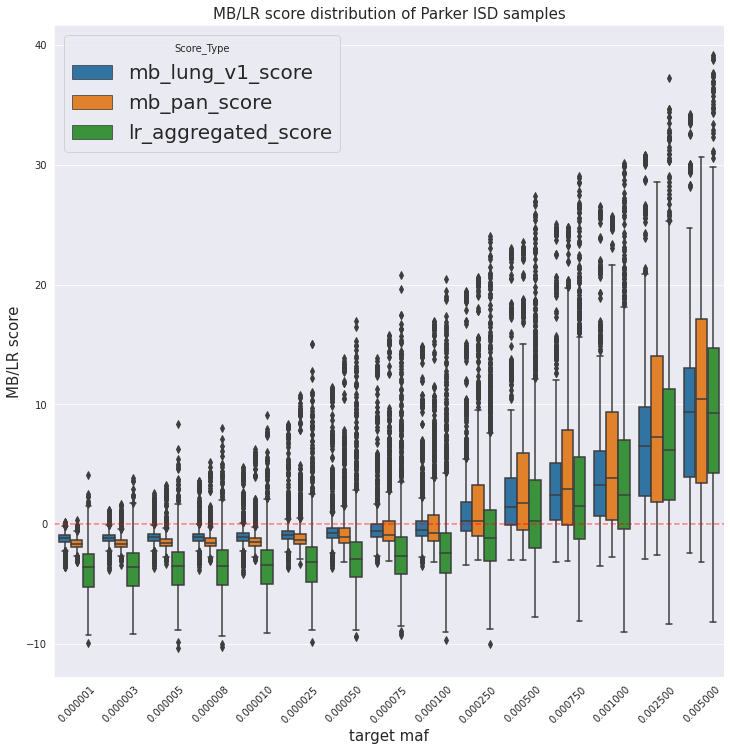

In [19]:
long_form_df = pd.melt(df_combined_scores, id_vars=["run_sample_id", "target_maf"], 
                       value_vars=["mb_lung_v1_score", "mb_pan_score", "lr_aggregated_score"],
                       var_name="Score_Type", value_name="Score_Value")

fig,ax0=plt.subplots(nrows=1, figsize=(12,12))
# sns.boxplot(x = "target_maf", y = "mb_score", data = df_cosmos_mb, color="skyblue")
# sns.boxplot(x="target_maf", y="mb_score", hue="stage", data=df_cosmos_mb)
sns.boxplot(x="target_maf", y="Score_Value", hue="Score_Type", data=long_form_df)
sns.set_style('darkgrid')
ax0.axhline(0, color='red', linestyle='--', alpha=0.5)
# plt.xlabel('target maf')
# plt.ylabel('MB score')
plt.title('MB/LR score distribution of Parker ISD samples', fontsize=15)
# plt.legend(loc='best')
plt.rc('legend',fontsize=20)
plt.xticks(rotation=45)
#plt.yticks(fontsize=25)
#plt.xticks(fontsize=25)
# ax0.set_xlim([0, 1])
# ax0.set_ylim([0, 1])
ax0.set_xlabel('target maf', fontsize=15)
ax0.set_ylabel('MB/LR score',fontsize=15)

# Format x-ticks labels
formatted_ticks = ['{:.6f}'.format(tick) for tick in long_form_df["target_maf"].unique()]
ax0.set_xticklabels(formatted_ticks)

plt.show()

In [13]:
#merge all LoDs of different callers of Parker ISD samples
df_lod_lung = pd.read_table(f"{work_dir}/parker_mb_lung_v1_interpolation_LoD.tsv")
df_lod_pan = pd.read_table(f"{work_dir}/parker_mb_pan_interpolation_LoD.tsv")
df_lod_lr_agg = pd.read_table(f"{work_dir}/parker_lr_aggregated_interpolation_LoD.tsv")

# Merge the dataframes on 'run_sample_id'
df_merged = pd.merge(df_lod_lung, df_lod_pan[['run_sample_id', 'LoD']], on="run_sample_id", how='inner', suffixes=('_lung', '_pan'))
df_lod = pd.merge(df_merged, df_lod_lr_agg[['run_sample_id', 'LoD']], on="run_sample_id", how='inner')
df_lod.rename(columns={'LoD': 'LoD_lr_agg'}, inplace=True)

#define the mapping of visit values to 'pre-treatment', 'on-treatment' and 'post-treatment'
visit_mapping = {
    'PRE-TREATMENT': 'pre-treatment',
    'ON-TREATMENT': 'on-treatment',
    '6 MONTHS POST 1ST DOSE': 'post-treatment',
    '12 MONTHS POST 1ST DOSE': 'post-treatment',
    '12 MONTHS POST EOSI': 'post-treatment',
    'Event of Special Interest': 'uncertain',
    'On-treatment': 'on-treatment',
    'EVENT OF SPECIAL INTEREST': 'uncertain',
    '4-6 WEEKS POST EOSI': 'post-treatment',
    '6 months post 1st dose': 'post-treatment',
    '6 MONTHS POST EOSI': 'post-treatment',
    'PD': 'post-treatment'
}

#define the mapping for grouping cancer types
cancer_mapping = {
    'Melanoma': 'other',
    'Head and neck squamous cell cancer (HNSCC)': 'other',
    'Hepatocellular carcinoma': 'other',
    'Endometrial cancer': 'other',
    'Bladder cancer': 'Bladder cancer',
    'Colon cancer': 'Colon cancer',
    'Gastrooesophageal cancer': 'Gastroesophageal cancer',
    'Small cell lung cancer': 'Small cell lung cancer',
    'Breast cancer': 'Breast cancer',
    'Renal cell carcinoma (RCC)': 'other',
    'Prostate cancer': 'Prostate cancer',
    'Merkel cell carcinoma (MCC)': 'other',
    'Urothelial carcinoma (UC)': 'other'
}

df_lod['cancer_type_new'] = df_lod['cancer_type'].map(cancer_mapping)
df_lod['treatment'] = df_lod['visit'].map(visit_mapping)
df_lod.head()

,run_sample_id,LoD_lung,mb_lung_v1_score,cancer_type,visit,LoD_pan,LoD_lr_agg,cancer_type_new,treatment
0,B00538617,0.000219,10.351198,Breast cancer,PRE-TREATMENT,0.000248,0.000413,Breast cancer,pre-treatment
1,B00538642,0.000318,8.883003,Head and neck squamous cell cancer (HNSCC),6 MONTHS POST 1ST DOSE,0.000212,0.001900,other,post-treatment
2,B00538643,0.000181,12.998222,Breast cancer,ON-TREATMENT,0.000160,0.000373,Breast cancer,on-treatment
3,B00538675,0.000226,8.329331,Colon cancer,ON-TREATMENT,0.000088,0.002015,Colon cancer,on-treatment
4,B00538684,0.000077,10.779733,Renal cell carcinoma (RCC),ON-TREATMENT,0.000027,0.000764,other,on-treatment


In [11]:
#melt data for LoD visulization
df_lod_plot = pd.melt(df_lod, id_vars=['run_sample_id', 'mb_lung_v1_score', 'cancer_type', 'visit', 'treatment', 'cancer_type_new'],
                      value_vars=['LoD_lung', 'LoD_pan', 'LoD_lr_agg'], 
                      var_name='Caller_Type', value_name='LoD')

df_lod_plot['Caller_Type'] = df_lod_plot['Caller_Type'].replace({'LoD_lung': 'MB_lung_v1', 'LoD_pan': 'MB_pan', 'LoD_lr_agg': 'LR_aggregated'})
df_lod_plot = df_lod_plot[df_lod_plot['LoD'] > 0]
df_lod_plot.head()

,run_sample_id,mb_lung_v1_score,cancer_type,visit,treatment,cancer_type_new,Caller_Type,LoD
0,B00538617,10.351198,Breast cancer,PRE-TREATMENT,pre-treatment,Breast cancer,MB_lung_v1,0.000219
1,B00538642,8.883003,Head and neck squamous cell cancer (HNSCC),6 MONTHS POST 1ST DOSE,post-treatment,other,MB_lung_v1,0.000318
2,B00538643,12.998222,Breast cancer,ON-TREATMENT,on-treatment,Breast cancer,MB_lung_v1,0.000181
3,B00538675,8.329331,Colon cancer,ON-TREATMENT,on-treatment,Colon cancer,MB_lung_v1,0.000226
4,B00538684,10.779733,Renal cell carcinoma (RCC),ON-TREATMENT,on-treatment,other,MB_lung_v1,0.000077


MB_lung_v1: Median = 0.00022, SD = 0.00108, CI = (0.00000, 0.00044)
MB_pan: Median = 0.00021, SD = 0.00122, CI = (-0.00004, 0.00045)
LR_aggregated: Median = 0.00058, SD = 0.00137, CI = (0.00031, 0.00085)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MB_lung_v1 vs. MB_pan: t-test paired samples, P_val:2.890e-01 t=-1.066e+00
MB_pan vs. LR_aggregated: t-test paired samples, P_val:9.391e-03 t=-2.650e+00
MB_lung_v1 vs. LR_aggregated: t-test paired samples, P_val:2.960e-03 t=-3.049e+00


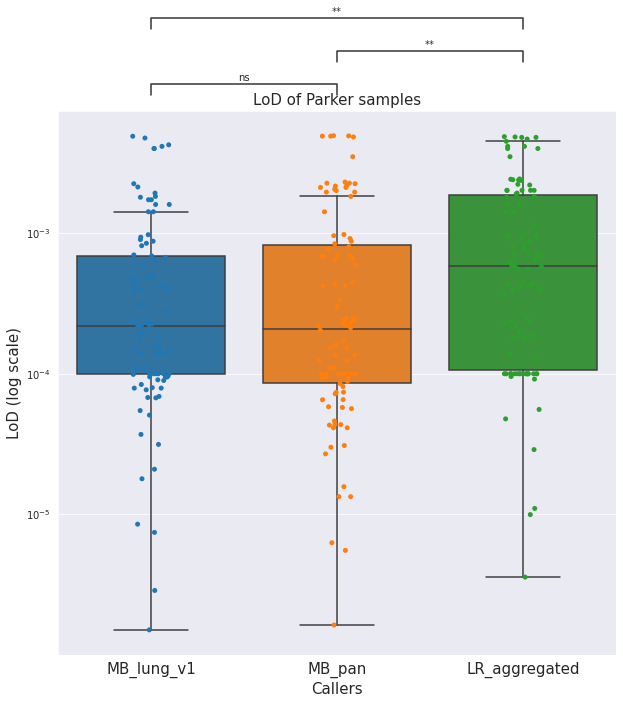

In [8]:
from statannotations.Annotator import Annotator

def boxplot_LoD(df):
    
    fig, ax0 = plt.subplots(nrows=1, figsize=(10, 10))
    sns.set_style('darkgrid')
    
    # Plotting the boxplot and stripplot with the specified order
    sns.boxplot(data=df, x="Caller_Type", y="LoD", ax=ax0, showfliers=False)
    sns.stripplot(data=df, x="Caller_Type", y="LoD", jitter=True, size=5, ax=ax0)
    
    #log scale
    ax0.set_yscale("log") 
    
    met_sites = df['Caller_Type'].unique()
    pairs = []
    
    for i, met_site in enumerate(met_sites):
        subgroup = df[df['Caller_Type'] == met_site]
        n = subgroup.shape[0]
        
        # Calculate median, CI, and SD
        median = subgroup['LoD'].median()
        sd = subgroup['LoD'].std()
        ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
        print(f'{met_site}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
        
        # Create pairs for statistical annotation
        for other_met_site in met_sites[i+1:]:
            pairs.append((met_site, other_met_site))
    
    # Creating an Annotator object and adding statistical annotation
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD')
    # annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # Setting other plot properties
    plt.title('LoD of Parker samples', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    plt.show()

boxplot_LoD(df_lod_plot)

pre-treatment     49
on-treatment      24
post-treatment    21
Name: treatment, dtype: int64
LR_aggregated - on-treatment: Median = 0.00069, SD = 0.00137, CI = (0.00011, 0.00127)
LR_aggregated - post-treatment: Median = 0.00069, SD = 0.00074, CI = (0.00035, 0.00103)
LR_aggregated - pre-treatment: Median = 0.00056, SD = 0.00153, CI = (0.00012, 0.00099)
MB_lung_v1 - on-treatment: Median = 0.00018, SD = 0.00126, CI = (-0.00035, 0.00072)
MB_lung_v1 - post-treatment: Median = 0.00020, SD = 0.00124, CI = (-0.00037, 0.00076)
MB_lung_v1 - pre-treatment: Median = 0.00022, SD = 0.00080, CI = (-0.00001, 0.00045)
MB_pan - on-treatment: Median = 0.00014, SD = 0.00143, CI = (-0.00047, 0.00074)
MB_pan - post-treatment: Median = 0.00017, SD = 0.00121, CI = (-0.00038, 0.00072)
MB_pan - pre-treatment: Median = 0.00023, SD = 0.00098, CI = (-0.00005, 0.00051)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1

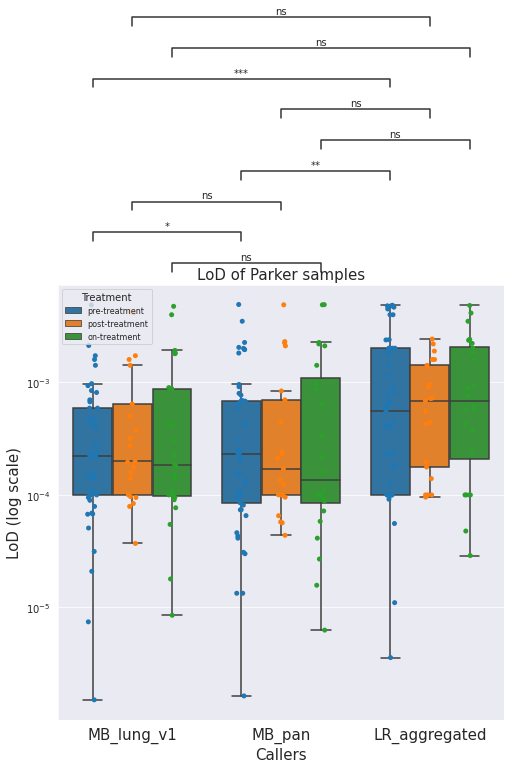

In [36]:
def boxplot_LoD_group(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(8, 8))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="Caller_Type", y="LoD", hue="treatment", ax=ax0, palette=palette, showfliers = False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="Caller_Type", y="LoD", hue="treatment", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log") 
    
    for i, (pre_post, group) in enumerate(df.groupby('Caller_Type')):
        for j, (cancer_type, subgroup) in enumerate(group.groupby('treatment')):
            
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{pre_post} - {cancer_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
    
    pairs = [
        (("MB_lung_v1", "pre-treatment"), ("MB_pan", "pre-treatment")),
        (("MB_lung_v1", "on-treatment"), ("MB_pan", "on-treatment")),
        (("MB_lung_v1", "post-treatment"), ("MB_pan", "post-treatment")),

        (("MB_lung_v1", "pre-treatment"), ("LR_aggregated", "pre-treatment")),
        (("MB_lung_v1", "on-treatment"), ("LR_aggregated", "on-treatment")),
        (("MB_lung_v1", "post-treatment"), ("LR_aggregated", "post-treatment")),

        (("MB_pan", "pre-treatment"), ("LR_aggregated", "pre-treatment")),
        (("MB_pan", "on-treatment"), ("LR_aggregated", "on-treatment")),
        (("MB_pan", "post-treatment"), ("LR_aggregated", "post-treatment")),
    ]
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD', hue='treatment')
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of Parker samples', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles[0:3], labels[0:3], title='Treatment', loc='upper left', fontsize = 8)  # Adjust depending on your number of categories

    plt.show()

df_lod_plot_treat = df_lod_plot[df_lod_plot["treatment"] != "uncertain"]
print(df_lod_plot_treat[df_lod_plot_treat["Caller_Type"] == "MB_lung_v1"].treatment.value_counts())
boxplot_LoD_group(df_lod_plot_treat)

LR_aggregated - Bladder cancer: Median = 0.00072, SD = 0.00076, CI = (0.00014, 0.00130)
LR_aggregated - Breast cancer: Median = 0.00039, SD = 0.00075, CI = (-0.00054, 0.00132)
LR_aggregated - Colon cancer: Median = 0.00062, SD = 0.00060, CI = (0.00006, 0.00117)
LR_aggregated - Gastroesophageal cancer: Median = 0.00010, SD = 0.00185, CI = (-0.00161, 0.00181)
LR_aggregated - Prostate cancer: Median = 0.00018, SD = 0.00181, CI = (-0.00207, 0.00242)
LR_aggregated - Small cell lung cancer: Median = 0.00059, SD = 0.00076, CI = (-0.00022, 0.00139)
LR_aggregated - other: Median = 0.00076, SD = 0.00150, CI = (0.00037, 0.00115)
MB_lung_v1 - Bladder cancer: Median = 0.00031, SD = 0.00028, CI = (0.00010, 0.00052)
MB_lung_v1 - Breast cancer: Median = 0.00018, SD = 0.00016, CI = (-0.00001, 0.00038)
MB_lung_v1 - Colon cancer: Median = 0.00014, SD = 0.00006, CI = (0.00009, 0.00019)
MB_lung_v1 - Gastroesophageal cancer: Median = 0.00015, SD = 0.00028, CI = (-0.00011, 0.00041)
MB_lung_v1 - Prostate canc

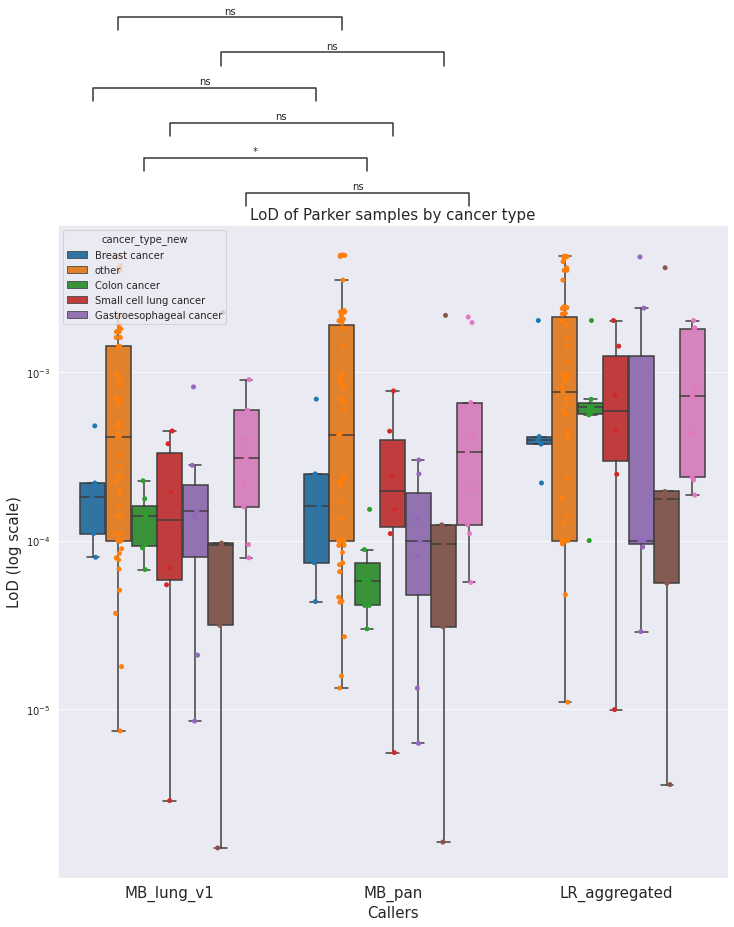

In [13]:
def boxplot_LoD_cancer_parker(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 12))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="Caller_Type", y="LoD", hue="cancer_type_new", ax=ax0, palette=palette, showfliers = False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="Caller_Type", y="LoD", hue="cancer_type_new", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log") 
    
    for i, (pre_post, group) in enumerate(df.groupby('Caller_Type')):
        for j, (cancer_type, subgroup) in enumerate(group.groupby('cancer_type_new')):
            
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{pre_post} - {cancer_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
    
    pairs = [
        (("MB_lung_v1", "Bladder cancer"), ("MB_pan", "Bladder cancer")),
        (("MB_lung_v1", "Colon cancer"), ("MB_pan", "Colon cancer")),
        (("MB_lung_v1", "Small cell lung cancer"), ("MB_pan", "Small cell lung cancer")),
        (("MB_lung_v1", "Breast cancer"), ("MB_pan", "Breast cancer")),
        (("MB_lung_v1", "Prostate cancer"), ("MB_pan", "Prostate cancer")),
        (("MB_lung_v1", "other"), ("MB_pan", "other")),
    ]
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD', hue='cancer_type_new')
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of Parker samples by cancer type', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles[0:5], labels[0:5], title='cancer_type_new', loc='upper left', fontsize = 10)  # Adjust depending on your number of categories

    plt.show()

# df_lod_cancer = df_lod_plot[(df_lod_plot["cancer_type"] == "Bladder cancer") | (df_lod_plot["cancer_type"] == "Colon cancer") | (df_lod_plot["cancer_type"] == "Small cell lung cancer") | (df_lod_plot["cancer_type"] == "Breast cancer") | (df_lod_plot["cancer_type"] == "Prostate cancer")]
boxplot_LoD_cancer_parker(df_lod_plot)

In [15]:
df_lod.cancer_type_new.value_counts()

other                      59
Bladder cancer              9
Colon cancer                7
Gastroesophageal cancer     7
Small cell lung cancer      6
Breast cancer               5
Prostate cancer             5
Name: cancer_type_new, dtype: int64

In [39]:
# Assuming df_lod_plot_treat is the DataFrame containing all the data including both MB_lung_v1 and MB_pan

# Filter the DataFrame for pre-treatment and the two caller types
pre_treatment_data = df_lod_plot_treat[df_lod_plot_treat['treatment'] == 'on-treatment']
lung_data = pre_treatment_data[pre_treatment_data['Caller_Type'] == 'MB_lung_v1']
pan_data = pre_treatment_data[pre_treatment_data['Caller_Type'] == 'MB_pan']

# Ensure the data is sorted by 'run_sample_id' so that the pairs match
lung_data = lung_data.sort_values('run_sample_id')
pan_data = pan_data.sort_values('run_sample_id')

# Perform the paired t-test on matched pairs
# We use 'merge' to make sure we only compare the same 'run_sample_id'
merged_data = pd.merge(lung_data, pan_data, on='run_sample_id', suffixes=('_lung', '_pan'))
t_stat, p_val = stats.ttest_rel(merged_data['LoD_lung'], merged_data['LoD_pan'])

print(f'T-statistic: {t_stat}, P-value: {p_val}')


T-statistic: -0.4376533232084207, P-value: 0.6657199809778211


### MRD AV samples

In [2]:
#merge all LoDs of different callers of MRD AV LoQ samples
df_lod_lung_loq = pd.read_table(f"{work_dir}/MRD_AV_LoQ_mb_lung_v1_interpolation_LoD.tsv")
df_lod_pan_loq = pd.read_table(f"{work_dir}/MRD_AV_LoQ_mb_pan_interpolation_LoD.tsv")
df_lod_lr_agg_loq = pd.read_table(f"{work_dir}/MRD_AV_LoQ_lr_aggregated_interpolation_LoD.tsv")

# Merge the dataframes on 'run_sample_id'
df_merged = pd.merge(df_lod_lung_loq, df_lod_pan_loq[['run_sample_id', 'LoD']], on="run_sample_id", how='inner', suffixes=('_lung', '_pan'))
df_lod_loq = pd.merge(df_merged, df_lod_lr_agg_loq[['run_sample_id', 'LoD']], on="run_sample_id", how='inner')
df_lod_loq.rename(columns={'LoD': 'LoD_lr_agg'}, inplace=True)


#melt data for LoD visulization
df_lod_loq_plot = pd.melt(df_lod_loq, id_vars=['run_sample_id', 'mb_lung_v1_score', 'cancer_type', 'input'],
                      value_vars=['LoD_lung', 'LoD_pan', 'LoD_lr_agg'], 
                      var_name='Caller_Type', value_name='LoD')

df_lod_loq_plot['Caller_Type'] = df_lod_loq_plot['Caller_Type'].replace({'LoD_lung': 'MB_lung_v1', 'LoD_pan': 'MB_pan', 'LoD_lr_agg': 'LR_aggregated'})
print(df_lod_lung_loq.cancer_type.value_counts())
df_lod_loq_plot.head()

PA        41
PR        41
CRC       18
LUNG      18
BREAST    18
Name: cancer_type, dtype: int64


,run_sample_id,mb_lung_v1_score,cancer_type,input,Caller_Type,LoD
0,KM12_20_15_R1,11.068937,CRC,15,MB_lung_v1,0.000092
1,H1648_20_15_R1,13.448403,LUNG,15,MB_lung_v1,0.000210
2,H2218_20_15_R3,18.632550,BREAST,15,MB_lung_v1,0.000064
3,H2218_20_15_R2,17.655217,BREAST,15,MB_lung_v1,0.000070
4,H1648_20_15_R2,14.558858,LUNG,15,MB_lung_v1,0.000172


In [3]:
#merge all LoDs of different callers of MRD AV Accuracy samples
df_lod_lung_acc = pd.read_table(f"{work_dir}/MRD_AV_Accuracy_mb_lung_v1_interpolation_LoD.tsv")
df_lod_pan_acc = pd.read_table(f"{work_dir}/MRD_AV_Accuracy_mb_pan_interpolation_LoD.tsv")
df_lod_lr_agg_acc = pd.read_table(f"{work_dir}/MRD_AV_Accuracy_lr_aggregated_interpolation_LoD.tsv")

# Merge the dataframes on 'run_sample_id'
df_merged = pd.merge(df_lod_lung_acc, df_lod_pan_acc[['run_sample_id', 'LoD']], on="run_sample_id", how='inner', suffixes=('_lung', '_pan'))
df_lod_acc = pd.merge(df_merged, df_lod_lr_agg_acc[['run_sample_id', 'LoD']], on="run_sample_id", how='inner')
df_lod_acc.rename(columns={'LoD': 'LoD_lr_agg'}, inplace=True)


#melt data for LoD visulization
df_lod_acc_plot = pd.melt(df_lod_acc, id_vars=['run_sample_id', 'mb_lung_v1_score', 'cancer_type'],
                      value_vars=['LoD_lung', 'LoD_pan', 'LoD_lr_agg'], 
                      var_name='Caller_Type', value_name='LoD')

df_lod_acc_plot['Caller_Type'] = df_lod_acc_plot['Caller_Type'].replace({'LoD_lung': 'MB_lung_v1', 'LoD_pan': 'MB_pan', 'LoD_lr_agg': 'LR_aggregated'})
print(df_lod_lung_acc.cancer_type.value_counts())
df_lod_acc_plot.head()

Lung adenocarcinoma                 26
Breast Carcinoma                    20
Colorectal adenocarcinoma           19
other                               17
Pancreatic ductal adenocarcinoma    13
Prostate adenocarcinoma              9
Gastric adenocarcinoma               2
Name: cancer_type, dtype: int64


,run_sample_id,mb_lung_v1_score,cancer_type,Caller_Type,LoD
0,Accu_HRD10_4507,8.459682,Colorectal adenocarcinoma,MB_lung_v1,0.000279
1,Accu_HRD3_4608,9.131087,Colorectal adenocarcinoma,MB_lung_v1,0.000201
2,Accu_HRD6_4405,8.918413,Breast Carcinoma,MB_lung_v1,0.000405
3,CA_298572,7.917861,Pancreatic ductal adenocarcinoma,MB_lung_v1,0.000418
4,CA_302203,12.478701,Breast Carcinoma,MB_lung_v1,0.000192


MB_lung_v1: Median = 0.00011, SD = 0.00006, CI = (0.00010, 0.00012)
MB_pan: Median = 0.00012, SD = 0.00007, CI = (0.00011, 0.00014)
LR_aggregated: Median = 0.00024, SD = 0.00017, CI = (0.00021, 0.00027)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MB_lung_v1 vs. MB_pan: t-test paired samples, P_val:6.850e-01 t=-4.065e-01
MB_pan vs. LR_aggregated: t-test paired samples, P_val:1.957e-25 t=-1.295e+01
MB_lung_v1 vs. LR_aggregated: t-test paired samples, P_val:2.657e-27 t=-1.369e+01


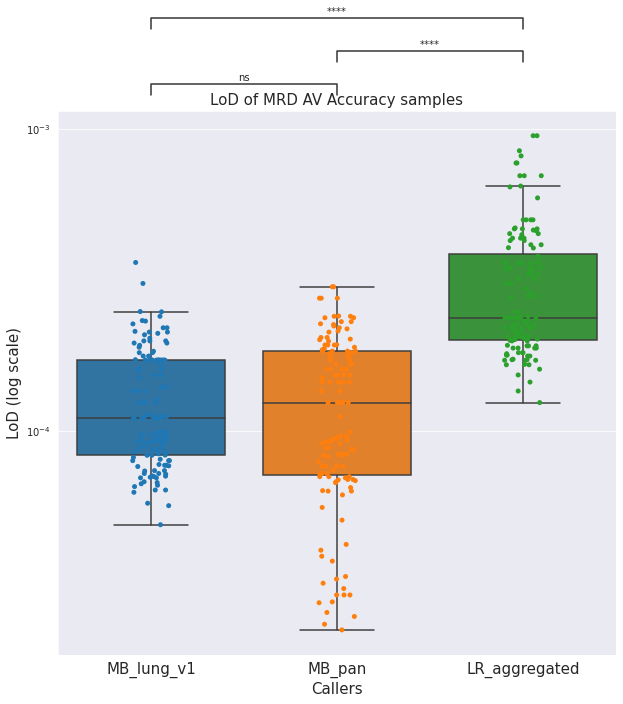

MB_lung_v1: Median = 0.00031, SD = 0.00084, CI = (0.00015, 0.00047)
MB_pan: Median = 0.00023, SD = 0.00075, CI = (0.00008, 0.00037)
LR_aggregated: Median = 0.00066, SD = 0.00119, CI = (0.00043, 0.00089)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MB_lung_v1 vs. MB_pan: t-test paired samples, P_val:5.685e-01 t=5.721e-01
MB_pan vs. LR_aggregated: t-test paired samples, P_val:4.341e-07 t=-5.391e+00
MB_lung_v1 vs. LR_aggregated: t-test paired samples, P_val:1.202e-04 t=-3.995e+00


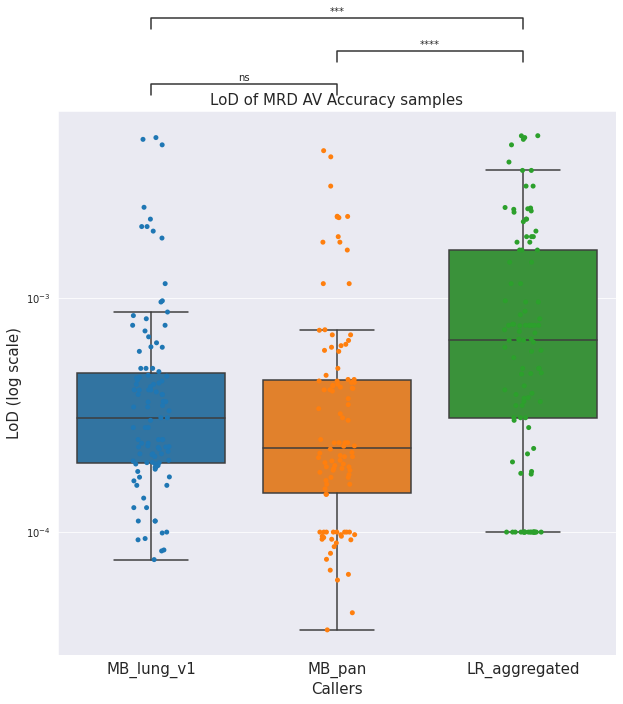

In [5]:
from statannotations.Annotator import Annotator

def boxplot_LoD_mrd(df):
    
    fig, ax0 = plt.subplots(nrows=1, figsize=(10, 10))
    sns.set_style('darkgrid')
    
    # Plotting the boxplot and stripplot with the specified order
    sns.boxplot(data=df, x="Caller_Type", y="LoD", ax=ax0, showfliers=False)
    sns.stripplot(data=df, x="Caller_Type", y="LoD", jitter=True, size=5, ax=ax0)
    
    #log scale
    ax0.set_yscale("log") 
    
    met_sites = df['Caller_Type'].unique()
    pairs = []
    
    for i, met_site in enumerate(met_sites):
        subgroup = df[df['Caller_Type'] == met_site]
        n = subgroup.shape[0]
        
        # Calculate median, CI, and SD
        median = subgroup['LoD'].median()
        sd = subgroup['LoD'].std()
        ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
        print(f'{met_site}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
        
        # Create pairs for statistical annotation
        for other_met_site in met_sites[i+1:]:
            pairs.append((met_site, other_met_site))
    
    # Creating an Annotator object and adding statistical annotation
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD')
    # annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    # Setting other plot properties
    plt.title('LoD of MRD AV Accuracy samples', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    plt.show()

# visulize the LoD 
boxplot_LoD_mrd(df_lod_loq_plot)
boxplot_LoD_mrd(df_lod_acc_plot)

MB_lung_v1: Median = 0.00020, SD = 0.00006, CI = (0.00018, 0.00022)
MB_pan: Median = 0.00019, SD = 0.00006, CI = (0.00017, 0.00021)
LR_aggregated: Median = 0.00047, SD = 0.00019, CI = (0.00040, 0.00053)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MB_lung_v1 vs. MB_pan: t-test paired samples, P_val:4.855e-01 t=-7.049e-01
MB_pan vs. LR_aggregated: t-test paired samples, P_val:2.615e-10 t=-8.730e+00
MB_lung_v1 vs. LR_aggregated: t-test paired samples, P_val:7.207e-11 t=-9.198e+00


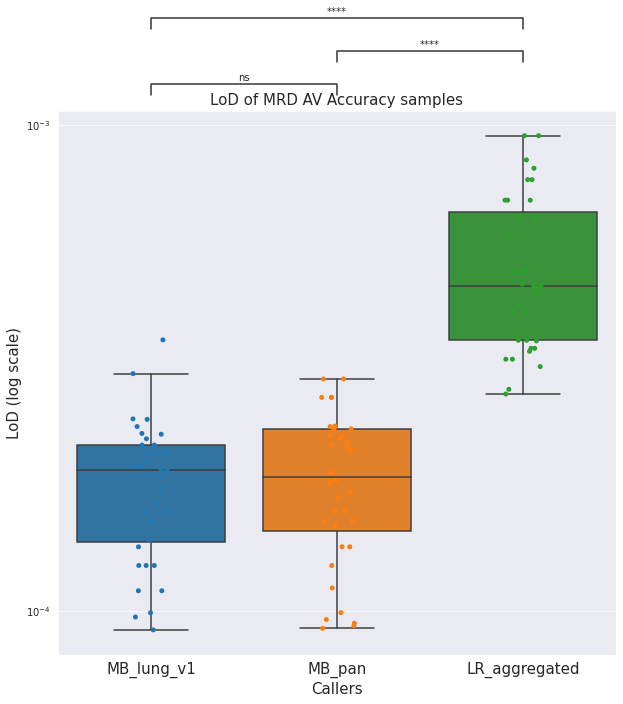

(108, 6)
MB_lung_v1: Median = 0.00009, SD = 0.00004, CI = (0.00009, 0.00010)
MB_pan: Median = 0.00009, SD = 0.00006, CI = (0.00008, 0.00010)
LR_aggregated: Median = 0.00022, SD = 0.00008, CI = (0.00020, 0.00023)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MB_lung_v1 vs. MB_pan: t-test paired samples, P_val:8.961e-01 t=-1.309e-01
MB_pan vs. LR_aggregated: t-test paired samples, P_val:4.246e-23 t=-1.298e+01
MB_lung_v1 vs. LR_aggregated: t-test paired samples, P_val:7.848e-27 t=-1.480e+01


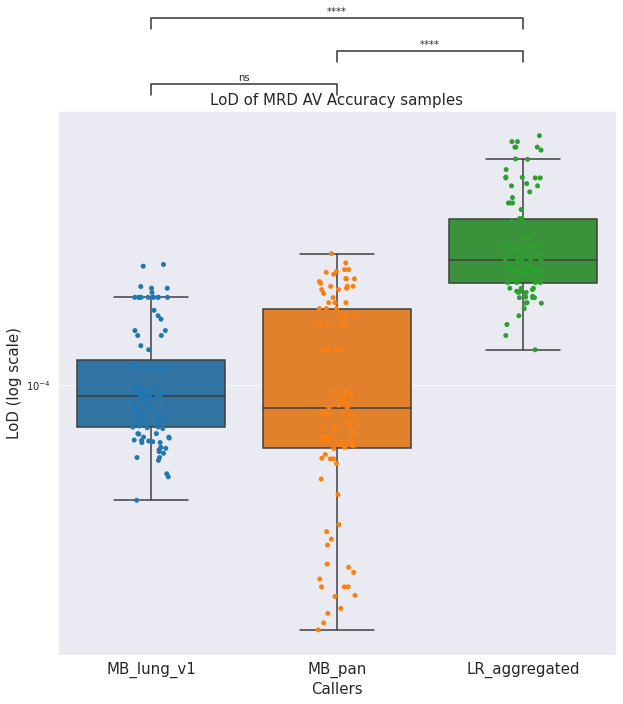

(300, 6)


In [8]:
df_5 = df_lod_loq_plot[df_lod_loq_plot["input"] == 5]
boxplot_LoD_mrd(df_5)
print(df_5.shape)
df_15 = df_lod_loq_plot[df_lod_loq_plot["input"] == 15]
boxplot_LoD_mrd(df_15)
print(df_15.shape)


LR_aggregated - 5: Median = 0.00047, SD = 0.00019, CI = (0.00040, 0.00053)
LR_aggregated - 15: Median = 0.00022, SD = 0.00008, CI = (0.00020, 0.00023)
MB_lung_v1 - 5: Median = 0.00020, SD = 0.00006, CI = (0.00018, 0.00022)
MB_lung_v1 - 15: Median = 0.00009, SD = 0.00004, CI = (0.00009, 0.00010)
MB_pan - 5: Median = 0.00019, SD = 0.00006, CI = (0.00017, 0.00021)
MB_pan - 15: Median = 0.00009, SD = 0.00006, CI = (0.00008, 0.00010)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MB_pan_5 vs. MB_pan_15: t-test independent samples, P_val:1.378e-11 t=7.396e+00
MB_lung_v1_5 vs. MB_lung_v1_15: t-test independent samples, P_val:3.586e-16 t=9.296e+00
LR_aggregated_5 vs. LR_aggregated_15: t-test independent samples, P_val:1.240e-22 t=1.186e+01
MB_lung_v1_15 vs. MB_pan_15: t-test independent samples, P_val:9.362e-01 t=-8.015e-02
MB_lung_v1_5 vs. MB_pan_5: t-test inde

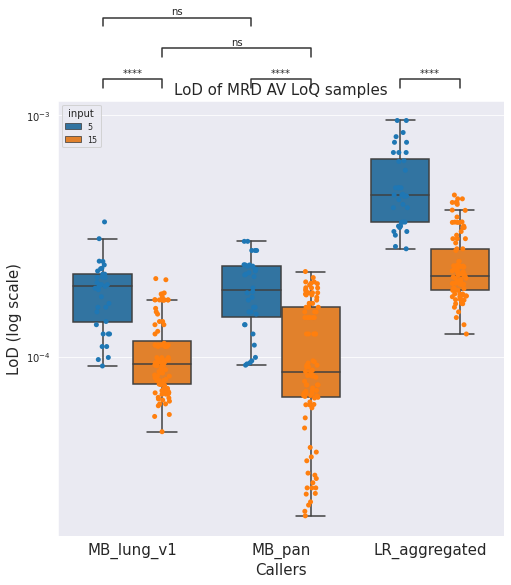

In [19]:
def boxplot_LoD_input(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(8, 8))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="Caller_Type", y="LoD", hue="input", ax=ax0, palette=palette, showfliers = False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="Caller_Type", y="LoD", hue="input", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log") 
    
    for i, (pre_post, group) in enumerate(df.groupby('Caller_Type')):
        for j, (cancer_type, subgroup) in enumerate(group.groupby('input')):
            
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{pre_post} - {cancer_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
  
    pairs = [
        (("MB_lung_v1", 15), ("MB_pan", 15)),
        (("MB_lung_v1", 5), ("MB_pan", 5)),
        (("MB_lung_v1", 5), ("MB_lung_v1", 15)),
        (("MB_pan", 5), ("MB_pan", 15)),
        (("LR_aggregated", 5), ("LR_aggregated", 15)),

#         (("MB_lung_v1", 15), ("LR_aggregated", 15)),
#         (("MB_lung_v1", 5), ("LR_aggregated", 5)),

#         (("MB_pan", 15), ("LR_aggregated", 15)),
#         (("MB_pan", 5), ("LR_aggregated", 5)),
    ]
    
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD', hue='input')
    annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of MRD AV LoQ samples', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles[0:2], labels[0:2], title='input', loc='upper left', fontsize = 8)  # Adjust depending on your number of categories

    plt.show()

boxplot_LoD_input(df_lod_loq_plot)

LR_aggregated - BREAST: Median = 0.00017, SD = 0.00002, CI = (0.00016, 0.00018)
LR_aggregated - CRC: Median = 0.00022, SD = 0.00003, CI = (0.00020, 0.00024)
LR_aggregated - LUNG: Median = 0.00021, SD = 0.00005, CI = (0.00018, 0.00023)
LR_aggregated - PA: Median = 0.00045, SD = 0.00019, CI = (0.00039, 0.00051)
LR_aggregated - PR: Median = 0.00024, SD = 0.00010, CI = (0.00021, 0.00027)
MB_lung_v1 - BREAST: Median = 0.00007, SD = 0.00001, CI = (0.00006, 0.00008)
MB_lung_v1 - CRC: Median = 0.00010, SD = 0.00002, CI = (0.00009, 0.00011)
MB_lung_v1 - LUNG: Median = 0.00010, SD = 0.00004, CI = (0.00008, 0.00012)
MB_lung_v1 - PA: Median = 0.00009, SD = 0.00004, CI = (0.00008, 0.00010)
MB_lung_v1 - PR: Median = 0.00018, SD = 0.00006, CI = (0.00016, 0.00020)
MB_pan - BREAST: Median = 0.00008, SD = 0.00001, CI = (0.00008, 0.00009)
MB_pan - CRC: Median = 0.00003, SD = 0.00001, CI = (0.00003, 0.00003)
MB_pan - LUNG: Median = 0.00016, SD = 0.00003, CI = (0.00014, 0.00017)
MB_pan - PA: Median = 0.000

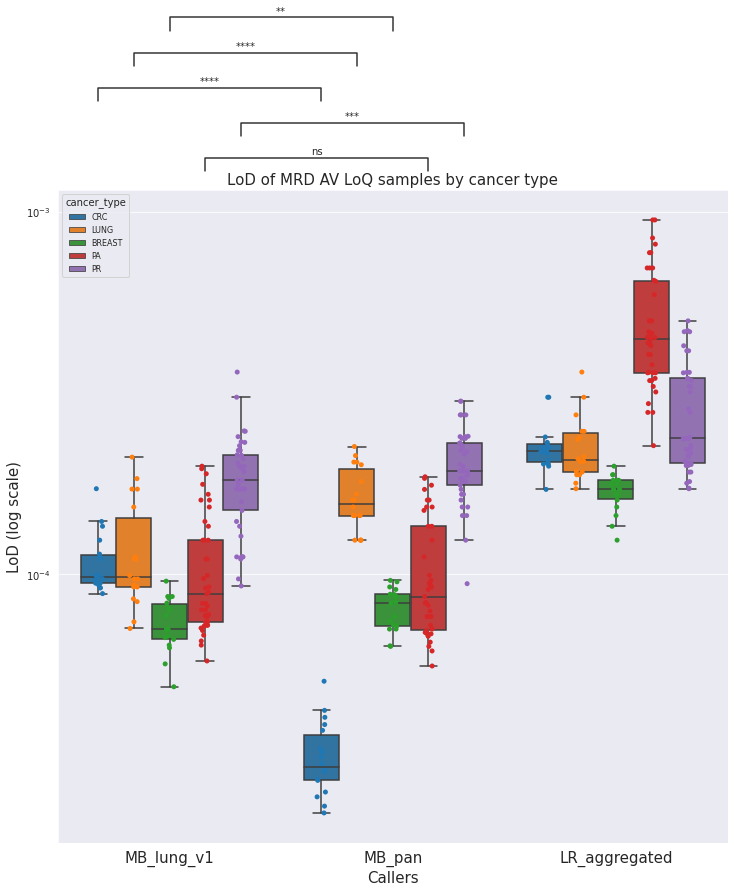

In [9]:
def boxplot_LoD_cancer(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 12))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="Caller_Type", y="LoD", hue="cancer_type", ax=ax0, palette=palette, showfliers = False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="Caller_Type", y="LoD", hue="cancer_type", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log") 
    
    for i, (pre_post, group) in enumerate(df.groupby('Caller_Type')):
        for j, (cancer_type, subgroup) in enumerate(group.groupby('cancer_type')):
            
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{pre_post} - {cancer_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
    
    pairs = [
        (("MB_lung_v1", "PA"), ("MB_pan", "PA")),
        (("MB_lung_v1", "PR"), ("MB_pan", "PR")),
        (("MB_lung_v1", "CRC"), ("MB_pan", "CRC")),
        (("MB_lung_v1", "LUNG"), ("MB_pan", "LUNG")),
        (("MB_lung_v1", "BREAST"), ("MB_pan", "BREAST")),

    ]
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD', hue='cancer_type')
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of MRD AV LoQ samples by cancer type', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles[0:5], labels[0:5], title='cancer_type', loc='upper left', fontsize = 8)  # Adjust depending on your number of categories

    plt.show()

boxplot_LoD_cancer(df_lod_loq_plot)

LR_aggregated - Breast Carcinoma: Median = 0.00038, SD = 0.00020, CI = (0.00029, 0.00048)
LR_aggregated - Colorectal adenocarcinoma: Median = 0.00076, SD = 0.00070, CI = (0.00043, 0.00110)
LR_aggregated - Gastric adenocarcinoma: Median = 0.00199, SD = 0.00056, CI = (-0.00301, 0.00700)
LR_aggregated - Lung adenocarcinoma: Median = 0.00120, SD = 0.00167, CI = (0.00052, 0.00187)
LR_aggregated - Pancreatic ductal adenocarcinoma: Median = 0.00066, SD = 0.00153, CI = (-0.00027, 0.00159)
LR_aggregated - Prostate adenocarcinoma: Median = 0.00050, SD = 0.00020, CI = (0.00035, 0.00065)
LR_aggregated - other: Median = 0.00076, SD = 0.00098, CI = (0.00026, 0.00127)
MB_lung_v1 - Breast Carcinoma: Median = 0.00029, SD = 0.00014, CI = (0.00023, 0.00036)
MB_lung_v1 - Colorectal adenocarcinoma: Median = 0.00022, SD = 0.00019, CI = (0.00012, 0.00031)
MB_lung_v1 - Gastric adenocarcinoma: Median = 0.00020, SD = 0.00005, CI = (-0.00023, 0.00063)
MB_lung_v1 - Lung adenocarcinoma: Median = 0.00066, SD = 0.00

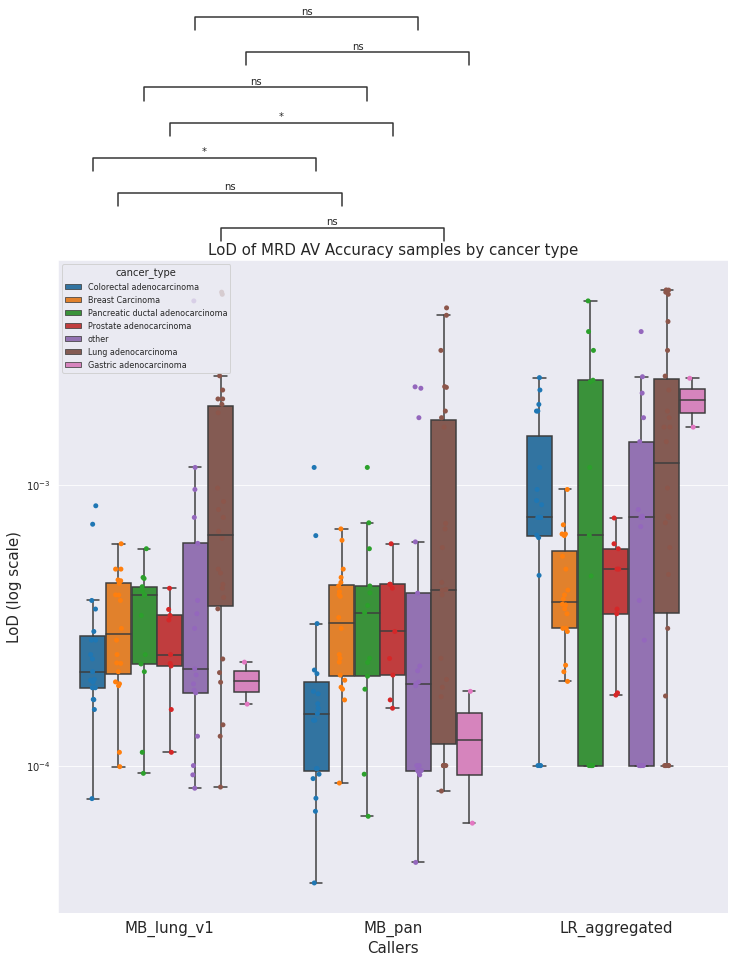

In [45]:
def boxplot_LoD_cancer_acc(df):
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 12))
    sns.set_style('darkgrid')
    
    # Defining a color palette
    palette = sns.color_palette("tab10")
    
    # Boxplot
    sns.boxplot(data=df, x="Caller_Type", y="LoD", hue="cancer_type", ax=ax0, palette=palette, showfliers = False)
    
    # Adding Stripplot
    sns.stripplot(data=df, x="Caller_Type", y="LoD", hue="cancer_type", jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, palette=palette, edgecolor='none')  
    ax0.set_yscale("log") 
    
    for i, (pre_post, group) in enumerate(df.groupby('Caller_Type')):
        for j, (cancer_type, subgroup) in enumerate(group.groupby('cancer_type')):
            
            median = subgroup['LoD'].median()
            sd = subgroup['LoD'].std()
            ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['LoD'])-1, loc=median, scale=stats.sem(subgroup['LoD']))
            print(f'{pre_post} - {cancer_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
    
    pairs = [
        (("MB_lung_v1", "Lung adenocarcinoma"), ("MB_pan", "Lung adenocarcinoma")),
        (("MB_lung_v1", "Breast Carcinoma"), ("MB_pan", "Breast Carcinoma")),
        (("MB_lung_v1", "Colorectal adenocarcinoma"), ("MB_pan", "Colorectal adenocarcinoma")),
        (("MB_lung_v1", "Prostate adenocarcinoma"), ("MB_pan", "Prostate adenocarcinoma")),
        (("MB_lung_v1", "Pancreatic ductal adenocarcinoma"), ("MB_pan", "Pancreatic ductal adenocarcinoma")),
        (("MB_lung_v1", "Gastric adenocarcinoma"), ("MB_pan", "Gastric adenocarcinoma")),
        (("MB_lung_v1", "other"), ("MB_pan", "other")),
    ]
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Caller_Type', y='LoD', hue='cancer_type')
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
    plt.title('LoD of MRD AV Accuracy samples by cancer type', fontsize=15)
    ax0.set_xlabel('Callers', fontsize=15)
    ax0.set_ylabel('LoD (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)
    
    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles[0:7], labels[0:7], title='cancer_type', loc='upper left', fontsize = 8)  # Adjust depending on your number of categories

    plt.show()

boxplot_LoD_cancer_acc(df_lod_acc_plot)

# OLD